**Notebooki ülemises osas** on graafikute koostamine.

**Alumises osas** on probleemsete trippide otsing üle liinide. Jäetud osaliselt poolikuks, kuna iga liini kohta on võimalik koostada graafik, mis kirjeldab hilinemistõenäosusi iga liini kohta ning info on kergemini loetav (vt cell nr 12, kus on see graafik koostatud liinile "4a").

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
data = pd.read_csv("puhastatud.csv")
data = data.drop("Unnamed: 0", axis=1)
routes = data.route_short_name.unique()
liinide_info = pd.read_csv("liinide_info.csv", delimiter=";")

liinide_info

,Liin,Väljumised ETKN,Väljumised R,Väljumised L,Väljumised P,Peatuste arv
0,1,88,91,51,48,33
1,2,86,87,47,46,25
2,3,53,53,46,46,45
3,4,88,90,51,49,38
4,5,9,9,9,9,29
5,6,66,66,46,46,48
6,7,51,51,47,47,41
7,8,48,48,46,46,41
8,9,8,8,7,7,54
9,9A,6,6,6,6,55


In [3]:
# Kõrvalekaldega väljumise esinemise tõenäosus

total = 0

for indx,row in liinide_info.iterrows():
    total += row["Väljumised ETKN"] * 4 * row["Peatuste arv"] * 5  
    total += row["Väljumised R"]  * row["Peatuste arv"] * 5 
    total += row["Väljumised L"]  * row["Peatuste arv"] * 5 
    total += row["Väljumised P"]  * row["Peatuste arv"] * 5 

len(data) / total

0.305424981348873

In [4]:
# Sisendiks on kindla liini kindla suuna juhud, väljundiks hilinemiste jaotus peatuste kaupa
def count_delay_percentages_per_stop(selection):

    # Samm 1. Kui palju on esinemisi
    total_occurrences = len(selection)
    # Samm 2. Grupeerime andmed peatuste järgi ning loendame
    occurrences_by_stop = selection.groupby(["route_direction_id", "stop_sequence"]).count().reset_index()
    # Samm 3. Leiame iga peatuse jaoks, kui suure osakaalu kogu liini hilinemistest moodustab vaadeldava peatuse hilinemised
    occurrences_by_stop["deviation"] = occurrences_by_stop["deviation"] / total_occurrences
   
    return occurrences_by_stop[["route_direction_id", "stop_sequence", "deviation"]]

# Sisendiks on kindla sõidu (tripi) kuupäevad; tagastab mitu seda sõitu kokku toimus vaadeldavas ajavahemikus
# Võib olla veidi ebatäpne, kuna on tehtud eeldusel, et trippide väljumispäevad on pärit hulgast {ETKNR, ETKNRLP, LP}
# Muidu, kuna igat päeva esines ajavahemikus 5 korda, siis üsna lollikindel
def get_trip_amount_by_dates(dates):
    total = 0
    s = set(pd.to_datetime(dates, format="%d.%m.%Y").dayofweek)
    if 0 in s or 1 in s or 2 in s or 3 in s or 4 in s:
        total += 5 * 5
    if 5 in s or 6 in s:
        total += 5 * 2
    return total


In [5]:
def get_heatmap_data(too_early):  
    heatmap_data = pd.DataFrame()

    for direction in data.route_direction_id.unique():
        selection = data[data.route_direction_id == direction]
        if too_early:
            selection = selection[selection.deviation > 0]
        else:
            selection = selection[selection.deviation < 0]
        d = count_delay_percentages_per_stop(selection)

        heatmap_data = heatmap_data.append(pd.pivot_table(d, values="deviation", 
                         index=['route_direction_id'], 
                         columns='stop_sequence'))
                  
    return heatmap_data

In [6]:
heatmap_early = get_heatmap_data(True)
heatmap_late = get_heatmap_data(False)

In [7]:
# Heatmapi andmete ühtlustamine, et mõlemas heatmapis oleksid olemas kõik samad suunadega liinid
# ning et mõlemas heatmapis oleksid peatuste arvud võrdsed

for i in heatmap_early.index:
    row = pd.Series({},name=i)
    if i not in heatmap_late.index:
        heatmap_late = heatmap_late.append(row)

for i in heatmap_late.index:
    row = pd.Series({},name=i)
    if i not in heatmap_early.index:
        heatmap_early = heatmap_early.append(row)

        
heatmap_early = heatmap_early.sort_values('route_direction_id', ascending=False)
heatmap_late = heatmap_late.sort_values('route_direction_id', ascending=False)

heatmap_early["55"] = pd.Series()
heatmap_early["56"] = pd.Series()
heatmap_early["57"] = pd.Series()

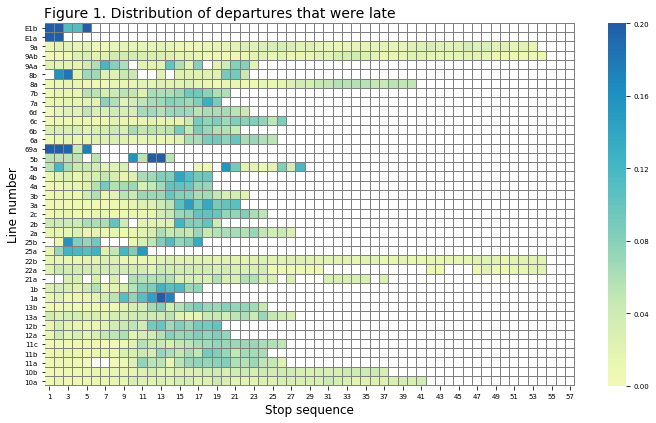

In [8]:
# Liiga hilja toimunud väljumiste osakaal sõltuvalt peatusest

s0=14
s1=12
s2=7
plt.figure(figsize=(12,6.67))

cmap = cm.get_cmap('YlGnBu', 256)
newcmp = ListedColormap(cmap(np.linspace(0.1, 0.75, 256)))

sns.heatmap(heatmap_early,
            cmap=newcmp,
            linewidths=0.004,
            linecolor='grey',
            vmin=0.0, vmax=0.2,
            cbar=True,
            square=True,
             yticklabels=True)
ax = plt.gca()
ax.set_ylim(len(heatmap_early), -0.0)

ax.set_title("Figure 1. Distribution of departures that were late", fontsize=s0, x=0.33)
ax.set_ylabel("Line number", fontsize=s1)
ax.set_xlabel("Stop sequence", fontsize=s1)
plt.xticks(rotation=0, fontsize=s2)
plt.yticks(rotation=0, fontsize=s2)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=s2)
#plt.savefig("late_stop_seq.png", dpi=350, transparent=True)

plt.show()

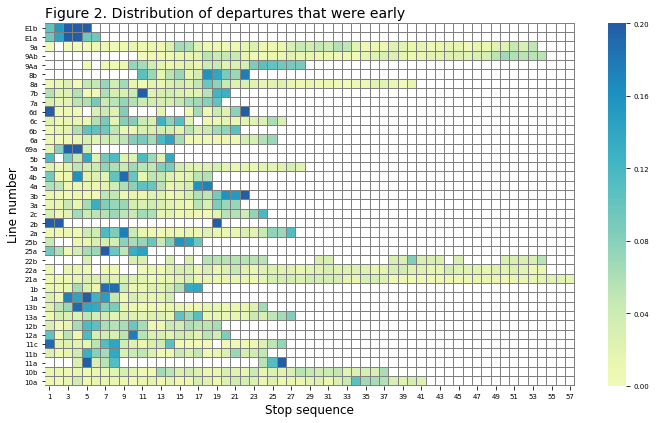

In [9]:
# Liiga vara toimunud väljumiste osakaal sõltuvalt peatusest

plt.figure(figsize=(12,6.67))
sns.heatmap(heatmap_late,
            cmap=newcmp,
            linewidths=0.004,
            linecolor='grey',
            vmin=0.0, vmax=0.2,
            cbar=True,
            square=True,
            yticklabels=True
           )
ax = plt.gca()
ax.set_ylim(len(heatmap_late), -0.0)
ax.set_title("Figure 2. Distribution of departures that were early", fontsize=s0,x=0.34)
ax.set_ylabel("Line number", fontsize=s1)
ax.set_xlabel("Stop sequence", fontsize=s1)
plt.yticks(rotation=0, fontsize=s2)
plt.xticks(fontsize=s2)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=s2)
cbar.ax.pad = 12
ax.pad = 0
#plt.savefig("early_stop_seq.png", dpi=350, transparent=True)

plt.show()

In [10]:
# Lisame andmetele veeru, mis täistund väljumine toimus

data["full_hour"] = pd.Series()

for r_d in data.route_direction_id.unique():
    data.loc[data.route_direction_id == r_d, "full_hour"] = data[data.route_direction_id == r_d].departure_time.apply(lambda x: x[0:2])

In [11]:
# Heatmapi info koostamine liinile "4a"

direction = "4a"

heatmap_data = pd.DataFrame()

selection = data[(data.route_direction_id == direction)][["trip_departure_time", "stop_name", "deviation", "a_date", "stop_sequence", "name"]]
selection = selection[selection.deviation > 0]

df = selection.groupby(["trip_departure_time", "name"]).count().reset_index()
df = df.loc[df.groupby('trip_departure_time')['stop_name'].idxmax()]
df = df[["trip_departure_time", "name"]]

for time in df.trip_departure_time:
    selection.loc[selection.trip_departure_time == time, "trip_departure_time"] = time[0:5] +" ("+ df[df.trip_departure_time == time].name.unique()[0][4:].zfill(3)+")"


d = selection.groupby(["trip_departure_time", "stop_name", "stop_sequence"]).count().reset_index()
sequence = selection[["stop_sequence", "stop_name"]].drop_duplicates().sort_values("stop_sequence")
for time in selection.trip_departure_time.unique():
    total = get_trip_amount_by_dates(selection[selection.trip_departure_time == time].a_date.unique())
    d.loc[d.trip_departure_time == time, "deviation"] = d["deviation"] / total

d.sort_values("stop_sequence")
    
heatmap_data = pd.pivot_table(d, values="deviation", 
         index=['trip_departure_time'], 
         columns="stop_name")
heatmap_data = heatmap_data.round(4)

heatmap_data = heatmap_data[sequence.stop_name]


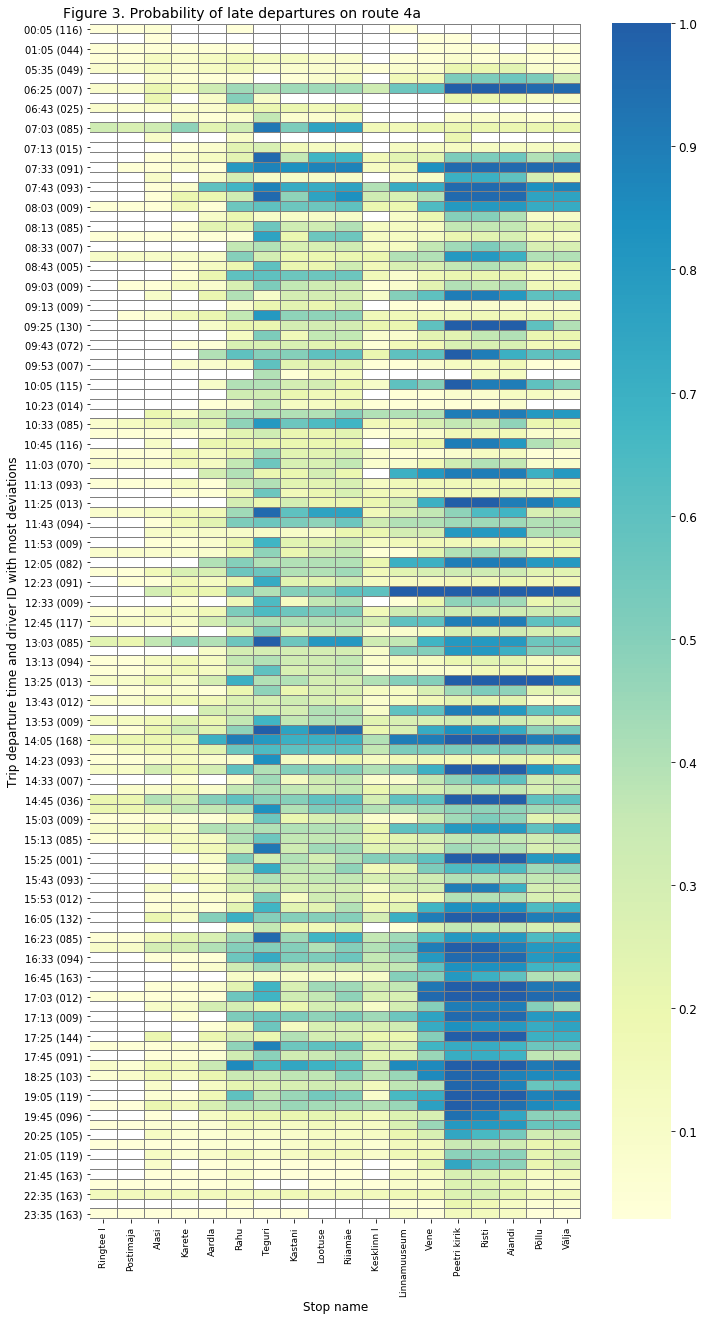

In [12]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.figure(figsize=(11 ,22))

cmap = cm.get_cmap('YlGnBu', 512)
newcmp = ListedColormap(cmap(np.linspace(0.0, 0.75, 256)))

sns.heatmap(heatmap_data,
            cmap=newcmp,
            linewidths=0.005,
            linecolor='grey',
            cbar=True,
            square=False,
            annot=False,
            xticklabels=True,
            cbar_kws=dict(ticks=[.1, .2, .3,.4,.5,.6,.7,.8,.9,1.0])
            )


ax = plt.gca()
ax.set_ylim(len(heatmap_data)+0.04, -0.08)
ax.set_title("Figure 3. Probability of late departures on route 4a",fontsize=s0,x=0.31)
ax.set_ylabel("Trip departure time and driver ID with most deviations",fontsize=s1)
ax.set_xlabel("Stop name",fontsize=s1)
plt.rcParams['ytick.labelsize'] = s2
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=s1)
plt.xticks(rotation=90, size=s1-3)
#plt.savefig("4a.png", dpi=300, transparent=True)

plt.show()

**NB!** Peatust loen probleemseks, kui 50% väljumistest on kõrvalekaldega

In [13]:
# Probleemseid peatuseid sisaldavate trippide leidmine ja iga liini kõige kõrgema kõrvaldekalde
# tõenäosusega peatusega tripi leidmine

pd.set_option("display.max_rows", 600)
lubatud_hilinemiste_osakaal = 0.5

worst_cases = []
problematic = []

for route_dir in data.route_direction_id.unique():
    selection = data[data.route_direction_id == route_dir]
    for trip in selection.trip_id.unique():
        selection.loc[selection.trip_id == trip, "times"] = get_trip_amount_by_dates(selection[selection.trip_id == trip].a_date.unique())

    grouped_by_trip_and_stop = selection[["trip_id", "stop_sequence", "deviation", "route_direction_id", "times"]].groupby(["route_direction_id","trip_id", "stop_sequence", "times"]).count() 
    grouped_by_trip_and_stop = grouped_by_trip_and_stop.reset_index()
    grouped_by_trip_and_stop["deviation"] = grouped_by_trip_and_stop.deviation / grouped_by_trip_and_stop.times
    grouped_by_trip_and_stop = grouped_by_trip_and_stop.groupby(["route_direction_id","trip_id", "stop_sequence", "times"]).first()


    problem = grouped_by_trip_and_stop[grouped_by_trip_and_stop>lubatud_hilinemiste_osakaal].dropna()
    problem["total_stops"] = selection.total_stops.unique()[0]
    
    if not problem.empty:
        problematic.append(problem)
    
    worst_case = (max(grouped_by_trip_and_stop.deviation),
                  grouped_by_trip_and_stop[grouped_by_trip_and_stop == max(grouped_by_trip_and_stop.deviation)].dropna().index[0])
    worst_cases.append(worst_case)
    

G:\Anaconda\envs\Andmeteadus\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
G:\Anaconda\envs\Andmeteadus\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [14]:
# Iga suuna halvim juhtum kujul (hilinemise_tõenäosus, (suund, halvim_trip, peatuse_järjekorranumber))

worst_cases.sort(key=lambda x: x[0])
worst_cases

[(0.11428571428571428, ('2b', 2385682, 8, 35.0)),
 (0.2, ('E1a', 2386999, 4, 35.0)),
 (0.2, ('69a', 2385642, 1, 35.0)),
 (0.28, ('5b', 2386775, 12, 25.0)),
 (0.45714285714285713, ('25a', 2385666, 9, 35.0)),
 (0.48, ('8b', 2386712, 22, 25.0)),
 (0.48, ('E1b', 2387000, 5, 25.0)),
 (0.5, ('21a', 2385688, 6, 10.0)),
 (0.5, ('22b', 2387352, 15, 10.0)),
 (0.5, ('22a', 2387353, 2, 10.0)),
 (0.6285714285714286, ('25b', 2385672, 15, 35.0)),
 (0.76, ('9Aa', 2386980, 24, 25.0)),
 (0.8, ('5a', 2386766, 4, 25.0)),
 (0.88, ('13a', 2386928, 17, 25.0)),
 (0.9, ('9a', 2386306, 30, 10.0)),
 (0.9, ('11a', 2385884, 5, 10.0)),
 (0.92, ('1b', 2387076, 16, 25.0)),
 (0.92, ('1a', 2387089, 7, 25.0)),
 (0.96, ('12b', 2386826, 12, 25.0)),
 (1.0, ('3a', 2385706, 19, 10.0)),
 (1.0, ('8a', 2385999, 19, 10.0)),
 (1.0, ('6b', 2385742, 7, 10.0)),
 (1.0, ('7a', 2386024, 18, 10.0)),
 (1.0, ('9Ab', 2386324, 50, 10.0)),
 (1.0, ('13b', 2385967, 20, 10.0)),
 (1.0, ('2c', 2387178, 18, 25.0)),
 (1.0, ('3b', 2385722, 19, 10.0)

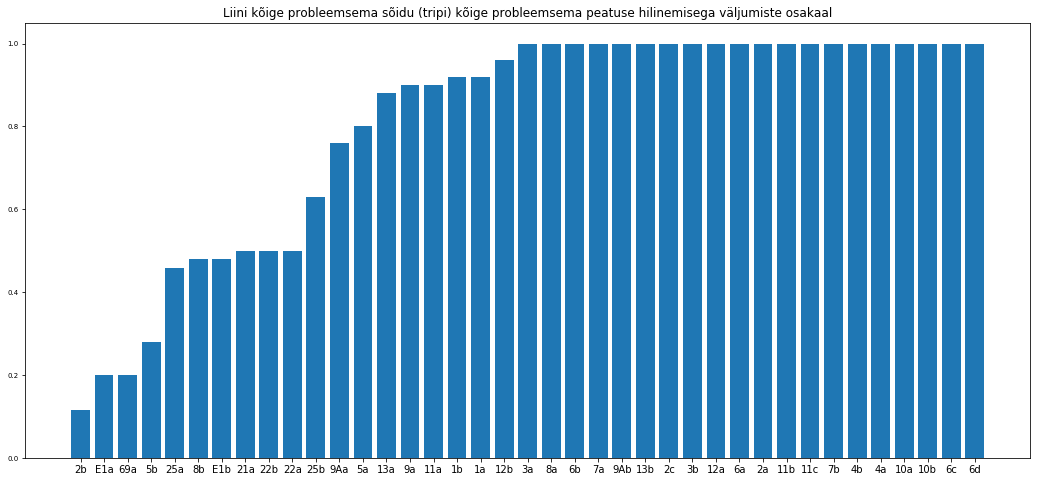

In [15]:
# Halvima tripi halvima peatuse kõrvalekalde tõenäosus

y = [a[0] for a in worst_cases]
x = [a[1][0] for a in worst_cases]
plt.rcParams['figure.figsize'] = [18,8]
plt.bar(x,y)
plt.title("Liini kõige probleemsema sõidu (tripi) kõige probleemsema peatuse hilinemisega väljumiste osakaal")
plt.show()

In [16]:
# Probleemset peatust sisaldavate trippide info kuvamine liinide kaupa
# (Peatus oli probleemne, kui 50% juhtudest olid kõrvalekaldega)

for problem in problematic:
    print("Liin " + problem.index[0][0])
    total_trips = len(data[data.route_direction_id == problem.index[0][0]].trip_id.unique())
    print("Kokku eri IDga sõite liinil " + str(total_trips))
    print("Kokku liinil peatuseid: " + str(data[data.route_direction_id == problem.index[0][0]].total_stops.unique()[0]))
    print("Probleemseid peatuseid üle trippide " + str(len(problem)))
    print("Mitme tripi juures oli see peatus probleemne")
    problem_distribution = problem.reset_index().stop_sequence.value_counts()
    print(problem_distribution)    
    print()

Liin 1b
Kokku eri IDga sõite liinil 139
Kokku liinil peatuseid: 18.0
Probleemseid peatuseid üle trippide 223
Mitme tripi juures oli see peatus probleemne
17    40
16    38
8     34
7     29
15    23
13    20
14    16
12     9
10     4
11     3
4      3
5      2
9      1
6      1
Name: stop_sequence, dtype: int64

Liin 1a
Kokku eri IDga sõite liinil 137
Kokku liinil peatuseid: 15.0
Probleemseid peatuseid üle trippide 242
Mitme tripi juures oli see peatus probleemne
5     45
13    37
4     25
7     24
3     23
14    20
12    20
11    14
9     12
6     12
10     6
8      4
Name: stop_sequence, dtype: int64

Liin 9Aa
Kokku eri IDga sõite liinil 2
Kokku liinil peatuseid: 29.0
Probleemseid peatuseid üle trippide 10
Mitme tripi juures oli see peatus probleemne
25    2
24    2
26    1
28    1
27    1
10    1
23    1
19    1
Name: stop_sequence, dtype: int64

Liin 3a
Kokku eri IDga sõite liinil 99
Kokku liinil peatuseid: 22.0
Probleemseid peatuseid üle trippide 207
Mitme tripi juures oli see pe

15    85
16    65
18    46
17    42
13    33
14    29
12    23
11    19
7     15
8      8
6      4
10     2
5      2
3      1
2      1
9      1
4      1
1      1
Name: stop_sequence, dtype: int64

Liin 4a
Kokku eri IDga sõite liinil 139
Kokku liinil peatuseid: 19.0
Probleemseid peatuseid üle trippide 516
Mitme tripi juures oli see peatus probleemne
15    73
16    68
14    68
18    50
17    48
7     48
13    41
10    29
9     25
12    22
6     22
8     19
5      2
11     1
Name: stop_sequence, dtype: int64

Liin 10a
Kokku eri IDga sõite liinil 30
Kokku liinil peatuseid: 42.0
Probleemseid peatuseid üle trippide 320
Mitme tripi juures oli see peatus probleemne
34    20
19    18
31    17
41    14
35    13
32    13
40    12
33    12
39    12
26    12
36    11
28    10
15    10
30    10
29    10
16    10
38     9
37     9
27     8
10     8
13     8
20     8
11     6
21     6
18     6
25     6
17     5
22     5
23     5
12     5
24     5
14     4
9      3
8      3
7      2
6      1
5      1
4

In [17]:
# Probleemset peatust sisaldavate liinide info kuvamine nii, et seda oleks võimalik kopeerida markdown cell'i 
# tabeliks, kuhu manuaalselt soovitusi lisada

problem_tables = []

for problem in problematic:
    problem_table = [[problem.index[0][0]], []]
    t_id = 0
    print(problem.index[0][0])
    for index,row in problem.iterrows():
        selection = data[data.trip_id == index[1]]
        if index[1] != t_id:
            t_id = index[1]
            print(t_id)
        stop_seq = index[2]
        stop_name = selection[selection.stop_sequence == stop_seq].stop_name.unique()[0]
        go_time = selection[selection.stop_sequence == stop_seq].departure_time.unique()[0]
        times = get_trip_amount_by_dates(selection.a_date.unique())
        wrong_times = selection[selection.stop_sequence == stop_seq].deviation.count()
        percent = wrong_times / times
        mean = selection[selection.stop_sequence == stop_seq].deviation.mean()
        std = selection[selection.stop_sequence == stop_seq].deviation.std()
        r = "|" + str(stop_seq) + "|" + stop_name +  "|" + go_time + "|" + str(wrong_times) + "|" + str(times) + "|" + str(percent) +"|" + str(mean) +"s |" + str(std) + "s | |"
        problem_table[1].append(r)
        print(r)
    print()
        
    problem_tables.append(problem_table)

1b
2385695
|7|Pikk|08:45:00|7|10|0.7|-40.285714285714285s |16.98739028136543s | |
|8|Atlantis|08:47:00|7|10|0.7|-43.0s |13.784048752090222s | |
2385697
|16|Riia ring|17:33:00|8|10|0.8|-72.875s |41.57072287078972s | |
|17|Teaduspark|17:34:00|6|10|0.6|-68.66666666666667s |42.4813684650891s | |
2385698
|7|Pikk|20:39:00|6|10|0.6|-49.833333333333336s |15.992706671063116s | |
|8|Atlantis|20:41:00|6|10|0.6|-42.5s |16.109003693587013s | |
|16|Riia ring|20:53:00|9|10|0.9|-80.88888888888889s |53.52906790811056s | |
|17|Teaduspark|20:54:00|9|10|0.9|-75.44444444444444s |57.64137210179662s | |
2385711
|15|Raja|07:24:00|8|10|0.8|211.625s |50.76820574223314s | |
|17|Teaduspark|07:26:00|6|10|0.6|221.66666666666666s |51.948692636741754s | |
2385712
|4|Kalda tee|14:14:00|7|10|0.7|43.142857142857146s |121.51739048579093s | |
|12|Lembitu|14:27:00|6|10|0.6|92.0s |193.104116993916s | |
|14|Soinaste II|14:30:00|6|10|0.6|83.83333333333333s |199.51482818744745s | |
|16|Riia ring|14:33:00|7|10|0.7|-15.0s |181.2

|15|Raja|11:50:00|15|25|0.6|267.73333333333335s |58.30519049017195s | |
2387029
|13|Kaare|13:07:00|14|25|0.56|225.5s |33.0820657898366s | |
2387031
|15|Raja|15:52:00|13|25|0.52|104.15384615384616s |192.1795367852008s | |
|16|Riia ring|15:53:00|14|25|0.56|91.57142857142857s |183.26639470609834s | |
|17|Teaduspark|15:55:00|16|25|0.64|47.1875s |183.63522492521236s | |
2387035
|13|Kaare|11:57:00|15|25|0.6|246.66666666666666s |62.19286438935242s | |
|14|Soinaste II|11:59:00|19|25|0.76|234.31578947368422s |65.00431834508205s | |
|15|Raja|12:00:00|19|25|0.76|256.42105263157896s |69.31194845645598s | |
2387037
|13|Kaare|14:37:00|18|25|0.72|251.94444444444446s |69.90874069917002s | |
|14|Soinaste II|14:39:00|15|25|0.6|252.46666666666667s |66.9230546082233s | |
|15|Raja|14:40:00|16|25|0.64|276.1875s |69.93732313054788s | |
|17|Teaduspark|14:43:00|15|25|0.6|235.53333333333333s |92.13954220688987s | |
2387038
|4|Kalda tee|17:13:00|15|25|0.6|112.66666666666667s |174.9590428262188s | |
|7|Pikk|17:18

|7|Pauluse|18:57:00|8|10|0.8|-28.125s |6.706872807586473s | |
2385730
|3|Riia ring|10:51:00|6|10|0.6|-48.833333333333336s |26.708924850444028s | |
|4|Raja|10:52:00|6|10|0.6|-36.0s |43.51091817004095s | |
|5|Soinaste I|10:54:00|8|10|0.8|-64.75s |52.25692025259156s | |
|6|Kaare|10:55:00|6|10|0.6|-65.16666666666667s |41.76801008746607s | |
2385731
|3|Riia ring|14:11:00|6|10|0.6|-30.0s |17.274258305351346s | |
2385732
|5|Soinaste I|18:14:00|7|10|0.7|-38.285714285714285s |18.580583823930162s | |
2385748
|5|Soinaste I|16:54:00|8|10|0.8|-40.625s |17.012075543146235s | |
2385749
|5|Soinaste I|19:54:00|6|10|0.6|-48.166666666666664s |16.987250120801388s | |
2385762
|13|Annelinna keskus|15:47:00|6|10|0.6|204.33333333333334s |30.349080161788535s | |
2385763
|5|Soinaste I|19:34:00|6|10|0.6|-51.166666666666664s |32.87805752575213s | |
2385776
|5|Soinaste I|11:54:00|7|10|0.7|-55.57142857142857s |38.100118734973094s | |
2385777
|3|Riia ring|15:51:00|7|10|0.7|-16.428571428571427s |5.623081683476386s | 

|13|Annelinna keskus|16:30:00|15|25|0.6|358.93333333333334s |164.2400102057381s | |
|14|Mõisavahe|16:32:00|13|25|0.52|340.53846153846155s |191.19127219646444s | |
2387121
|3|Riia ring|12:21:00|14|25|0.56|-28.5s |14.086272641230432s | |
|5|Soinaste I|12:24:00|14|25|0.56|-29.142857142857142s |10.567418306773405s | |
2387122
|3|Riia ring|13:41:00|13|25|0.52|-8.384615384615385s |77.37951759729278s | |
|13|Annelinna keskus|13:57:00|15|25|0.6|264.93333333333334s |107.75863682101685s | |
2387123
|4|Raja|15:03:00|15|25|0.6|0.7333333333333333s |98.36772602744014s | |
|5|Soinaste I|15:05:00|17|25|0.68|-18.0s |106.9339749565123s | |
|7|Pauluse|15:09:00|16|25|0.64|-45.0625s |84.16053608035855s | |
2387124
|5|Soinaste I|17:54:00|14|25|0.56|-8.0s |67.60405085723556s | |
|9|Pikk|18:02:00|14|25|0.56|303.14285714285717s |169.04248766911425s | |
|11|Eeden|18:05:00|14|25|0.56|327.57142857142856s |173.45880215185403s | |
|12|Kalda tee|18:06:00|16|25|0.64|329.875s |172.94888454877835s | |
|13|Annelinna kes

|12|Kalda tee|17:28:00|20|25|0.8|404.2s |176.02320421198058s | |
|13|Annelinna keskus|17:30:00|20|25|0.8|396.55s |171.61384896882518s | |
|14|Mõisavahe|17:32:00|18|25|0.72|394.3333333333333s |164.95703540441s | |
2387160
|13|Annelinna keskus|18:47:00|15|25|0.6|246.0s |52.418644447508235s | |
2387163
|13|Annelinna keskus|19:07:00|14|25|0.56|253.64285714285714s |52.56440319756788s | |
2387170
|3|Riia ring|20:51:00|15|25|0.6|-33.733333333333334s |16.705288583758936s | |
|5|Soinaste I|20:54:00|17|25|0.68|-50.8235294117647s |27.418596093978007s | |
|6|Kaare|20:55:00|13|25|0.52|-53.07692307692308s |30.39589209762162s | |
|7|Pauluse|20:57:00|13|25|0.52|-42.46153846153846s |22.389042649680906s | |

9Aa
2386319
|10|Jänese|07:17:00|7|10|0.7|-56.0s |25.152865973217974s | |
|19|Kasarmu|07:29:00|6|10|0.6|-81.33333333333333s |55.29074666403653s | |
|24|Kalda tee|07:41:00|7|10|0.7|-75.85714285714286s |78.0457741145724s | |
|25|Kaunase puiestee|07:44:00|6|10|0.6|-126.33333333333333s |119.2152115573623

|19|Kivilinna|06:34:00|15|25|0.6|-53.733333333333334s |31.51749325299176s | |
2386396
|15|Aida|11:35:00|15|25|0.6|253.86666666666667s |80.41931774559312s | |
|16|Silla I|11:36:00|16|25|0.64|279.5s |84.55136505895888s | |
|18|Sõpruse puiestee|11:41:00|15|25|0.6|276.26666666666665s |90.4453004912493s | |
|21|Annemõisa|11:45:00|13|25|0.52|272.6923076923077s |89.9021547900685s | |
2386397
|16|Silla I|13:16:00|14|25|0.56|287.35714285714283s |77.74772531211953s | |
|18|Sõpruse puiestee|13:21:00|14|25|0.56|283.2142857142857s |80.44413118281682s | |
2386398
|15|Aida|14:55:00|15|25|0.6|294.73333333333335s |63.53004538536602s | |
|16|Silla I|14:56:00|20|25|0.8|298.1s |77.77626481402314s | |
|17|Anne|15:00:00|17|25|0.68|266.70588235294116s |78.99031958560046s | |
|18|Sõpruse puiestee|15:01:00|21|25|0.84|297.85714285714283s |77.47405095532679s | |
|19|Kivilinna|15:03:00|17|25|0.68|272.94117647058823s |77.10907095491044s | |
|20|Rahumäe|15:04:00|20|25|0.8|278.4s |81.62068881175448s | |
|21|Annemõis

|18|Sõpruse puiestee|19:01:00|21|25|0.84|266.6666666666667s |84.41938955792878s | |
|20|Rahumäe|19:04:00|13|25|0.52|274.53846153846155s |83.10296363008099s | |
|21|Annemõisa|19:05:00|14|25|0.56|276.64285714285717s |83.92268157963306s | |
2386971
|19|Kivilinna|23:03:00|17|25|0.68|-76.82352941176471s |53.19684588173161s | |
|20|Rahumäe|23:04:00|14|25|0.56|-79.92857142857143s |51.62209468183812s | |
|21|Annemõisa|23:05:00|15|25|0.6|-79.2s |55.11701837260171s | |

8a
2385986
|38|Melissi|09:28:00|6|10|0.6|226.33333333333334s |151.49741471941584s | |
2385987
|13|Lembitu|13:23:00|6|10|0.6|200.0s |15.735310610216755s | |
|29|Pauluse|13:44:00|6|10|0.6|239.83333333333334s |46.69653805868982s | |
|30|Riiamäe|13:46:00|7|10|0.7|219.28571428571428s |121.82188402980569s | |
|31|Kesklinn I|13:50:00|7|10|0.7|90.85714285714286s |140.9402102210113s | |
|33|Vene|13:52:00|6|10|0.6|278.1666666666667s |79.46676454132675s | |
|34|Peetri|13:53:00|7|10|0.7|253.85714285714286s |142.70182032409232s | |
|35|Jänese

|11|Riiamäe|08:19:00|17|25|0.68|299.6470588235294s |126.47229992001736s | |
|12|Pauluse|08:21:00|14|25|0.56|284.14285714285717s |149.72377496980494s | |
|13|Lembitu|08:22:00|15|25|0.6|305.26666666666665s |152.75726153731924s | |
|14|Kaare|08:24:00|14|25|0.56|282.57142857142856s |156.8569727175362s | |
|16|Lemmatsi|08:27:00|16|25|0.64|279.3125s |155.92079987395311s | |
|28|Kaare|08:46:00|13|25|0.52|271.84615384615387s |78.03721991657373s | |
|29|Pauluse|08:48:00|14|25|0.56|293.7857142857143s |72.97647520993279s | |
|30|Riiamäe|08:50:00|15|25|0.6|312.93333333333334s |83.01330931729879s | |
|31|Kesklinn I|08:52:00|23|25|0.92|319.2608695652174s |96.93775762702035s | |
|32|Linnamuuseum|08:54:00|23|25|0.92|314.3478260869565s |95.92734404729644s | |
|33|Vene|08:56:00|18|25|0.72|298.1666666666667s |94.22579264723646s | |
|34|Peetri|08:57:00|18|25|0.72|319.5s |98.7130422278756s | |
|35|Jänese|08:58:00|17|25|0.68|312.05882352941177s |97.00739056138667s | |
2386673
|18|Kraavi|12:00:00|14|25|0.56|

|36|Killustiku|10:28:00|17|25|0.68|284.3529411764706s |59.73686171082997s | |
|37|Mõisapargi|10:29:00|18|25|0.72|261.6111111111111s |89.96282819874183s | |
|38|Melissi|10:31:00|18|25|0.72|282.3333333333333s |126.17681338223008s | |
|39|Sinepi|10:31:00|17|25|0.68|307.47058823529414s |90.39366518668415s | |
|40|Vahi|10:33:00|17|25|0.68|270.7647058823529s |108.56134752512327s | |
2386699
|7|Orava|13:11:00|14|25|0.56|-28.0s |89.46851616415344s | |
|18|Kraavi|13:30:00|13|25|0.52|-63.38461538461539s |49.231660648980856s | |
|19|Roopa|13:36:00|13|25|0.52|-120.61538461538461s |85.58186963520025s | |
|28|Kaare|13:45:00|15|25|0.6|213.33333333333334s |53.93735343190371s | |
|30|Riiamäe|13:49:00|17|25|0.68|244.41176470588235s |57.22877207263123s | |
|31|Kesklinn I|13:51:00|18|25|0.72|306.22222222222223s |68.91559676244691s | |
|32|Linnamuuseum|13:53:00|23|25|0.92|296.0869565217391s |74.93446412061328s | |
|33|Vene|13:54:00|23|25|0.92|322.17391304347825s |77.45887599465752s | |
|34|Peetri|13:55:00|

|28|Kaare|07:46:00|17|25|0.68|277.94117647058823s |88.62030706068114s | |
|29|Pauluse|07:48:00|20|25|0.8|339.15s |117.44753587968769s | |
|30|Riiamäe|07:50:00|22|25|0.88|368.40909090909093s |133.95011832445016s | |
|31|Kesklinn I|07:52:00|25|25|1.0|375.96s |147.50973979142304s | |
|32|Linnamuuseum|07:54:00|25|25|1.0|383.0s |143.57170101845745s | |
|33|Vene|07:56:00|25|25|1.0|354.88s |146.89319249032613s | |
|34|Peetri|07:57:00|25|25|1.0|391.72s |147.72652661816247s | |
|35|Jänese|07:58:00|25|25|1.0|378.76s |149.11720222697312s | |
|36|Killustiku|08:01:00|22|25|0.88|343.3636363636364s |148.490995543756s | |
|37|Mõisapargi|08:02:00|21|25|0.84|349.3809523809524s |149.15645349446874s | |
|38|Melissi|08:04:00|21|25|0.84|362.4761904761905s |126.40633648975793s | |
|39|Sinepi|08:05:00|17|25|0.68|395.94117647058823s |156.148355173948s | |
|40|Vahi|08:06:00|20|25|0.8|376.15s |153.57777902589396s | |
2386726
|18|Kraavi|11:00:00|18|25|0.72|-59.611111111111114s |46.127877099988396s | |
|19|Roopa|1

|13|Lembitu|18:21:00|13|25|0.52|247.30769230769232s |113.65252938627206s | |
|19|Roopa|18:36:00|13|25|0.52|-108.23076923076923s |63.64766799361655s | |
|31|Kesklinn I|18:52:00|13|25|0.52|245.30769230769232s |46.076719746137556s | |
|32|Linnamuuseum|18:54:00|14|25|0.56|240.0s |39.72985701536741s | |
|33|Vene|18:55:00|14|25|0.56|269.92857142857144s |35.26485346786358s | |
|34|Peetri|18:57:00|13|25|0.52|237.69230769230768s |32.81103629213961s | |
|35|Jänese|18:58:00|13|25|0.52|230.30769230769232s |32.47405275853482s | |
2386742
|14|Kaare|21:53:00|15|25|0.6|-46.666666666666664s |52.786181452923394s | |
|15|Soinaste III|21:55:00|19|25|0.76|-56.473684210526315s |50.775506366590044s | |
|17|Raudtee I|21:58:00|19|25|0.76|-66.52631578947368s |37.42009029778973s | |
|18|Kraavi|22:00:00|20|25|0.8|-116.95s |42.23926210479883s | |
|19|Roopa|22:03:00|17|25|0.68|-161.05882352941177s |74.34671360275053s | |
|20|Kesa|22:04:00|15|25|0.6|-134.73333333333332s |96.62628056195734s | |
|22|Mesika|22:06:00|17

|15|Risti|05:43:00|17|25|0.68|-40.411764705882355s |128.36036129951168s | |
|16|Aiandi|05:44:00|15|25|0.6|-13.533333333333333s |130.19812740954603s | |
|23|Atlantis|05:54:00|14|25|0.56|-9.0s |94.77747216912482s | |
|27|Linda|06:03:00|18|25|0.72|-40.388888888888886s |63.243822194358515s | |
|28|Tähe Erakliinik|06:05:00|17|25|0.68|-80.52941176470588s |40.7770119783482s | |
|29|Forseliuse|06:06:00|13|25|0.52|-69.15384615384616s |36.386458456056964s | |
|32|Raudtee III|06:12:00|14|25|0.56|-70.78571428571429s |43.12803580650842s | |
|51|Kalda tee|06:44:00|17|25|0.68|-59.294117647058826s |35.43791173637767s | |
|52|Annelinna keskus|06:45:00|15|25|0.6|-62.06666666666667s |33.35837154869753s | |
|53|Mõisavahe|06:47:00|19|25|0.76|-98.63157894736842s |49.412335983723956s | |
2386973
|22|Vene|07:38:00|21|25|0.84|357.14285714285717s |118.79953102360537s | |
|23|Atlantis|07:40:00|21|25|0.84|333.7142857142857s |117.37978652951405s | |
|24|Kesklinn VI|07:43:00|21|25|0.84|332.1904761904762s |129.69410

|7|Palmihoone|16:00:00|8|10|0.8|-83.875s |35.96600577529525s | |
|21|Optika|16:21:00|6|10|0.6|43.333333333333336s |150.40434390890002s | |
2385919
|4|Kreutzwaldi|17:15:00|9|10|0.9|-42.44444444444444s |27.532304258412115s | |
|5|Hurda|17:17:00|7|10|0.7|-87.14285714285714s |39.27861407699518s | |
|6|Lai|17:19:00|7|10|0.7|-90.14285714285714s |48.07088020631122s | |
|7|Palmihoone|17:20:00|6|10|0.6|-75.0s |46.307666751845744s | |
2385921
|16|Ropkamõisa|19:32:00|6|10|0.6|-47.5s |26.36474919281426s | |
|19|Tamme puiestee|19:37:00|6|10|0.6|-83.5s |43.22383601671652s | |
|20|FI|19:39:00|6|10|0.6|-93.0s |44.04543109109048s | |
|21|Optika|19:41:00|6|10|0.6|-138.66666666666666s |41.90306273611353s | |
2385922
|5|Hurda|20:37:00|6|10|0.6|-52.666666666666664s |19.6638416050035s | |
|6|Lai|20:39:00|9|10|0.9|-45.77777777777778s |27.80187843373977s | |
|7|Palmihoone|20:40:00|7|10|0.7|-57.714285714285715s |24.32909291167186s | |
2385923
|5|Hurda|21:57:00|7|10|0.7|-59.857142857142854s |39.9809478436441s |

|7|Palmihoone|14:40:00|8|10|0.8|-87.125s |39.58151624901993s | |
|18|Raudtee III|14:55:00|6|10|0.6|-50.833333333333336s |56.2082437607391s | |
|19|Tamme puiestee|14:57:00|6|10|0.6|-95.0s |53.97036223706489s | |
|20|FI|14:59:00|6|10|0.6|-101.33333333333333s |50.9496483468401s | |
|21|Optika|15:01:00|7|10|0.7|-129.28571428571428s |65.80707734409293s | |
2386023
|3|Tartu Näitused|18:53:00|6|10|0.6|-28.5s |19.856988694160048s | |
|4|Kreutzwaldi|18:55:00|8|10|0.8|-64.25s |35.08255569774976s | |
|5|Hurda|18:57:00|9|10|0.9|-101.44444444444444s |56.63283303683278s | |
|6|Lai|18:59:00|9|10|0.9|-116.44444444444444s |62.25775275239043s | |
|7|Palmihoone|19:00:00|9|10|0.9|-116.44444444444444s |69.18292981493178s | |
|8|Raeplats|19:01:00|8|10|0.8|-85.5s |32.49175719646886s | |
|11|Silla II|19:06:00|7|10|0.7|-41.57142857142857s |13.86671245413686s | |
|12|Vaba|19:07:00|6|10|0.6|-42.5s |14.6935359937627s | |
|13|Saekoja|19:08:00|6|10|0.6|-40.833333333333336s |22.049187437787058s | |
|14|Tehase|19:09:

|14|Tehase|08:34:00|14|25|0.56|297.7857142857143s |94.75732451610561s | |
|15|E-Kaubamaja|08:35:00|15|25|0.6|340.4s |123.15831855206301s | |
|16|Ropkamõisa|08:37:00|13|25|0.52|290.7692307692308s |137.45796560291552s | |
|17|Autokeskus|08:38:00|16|25|0.64|314.625s |111.34623178775891s | |
|18|Raudtee III|08:40:00|15|25|0.6|317.93333333333334s |132.2159849135749s | |
|19|Tamme puiestee|08:42:00|14|25|0.56|281.14285714285717s |130.35210136269507s | |
|20|FI|08:44:00|16|25|0.64|261.3125s |147.4126718885908s | |
|21|Optika|08:46:00|15|25|0.6|221.8s |178.92344731756094s | |
2387525
|5|Hurda|11:22:00|13|25|0.52|-49.69230769230769s |29.195846209648312s | |
|6|Lai|11:24:00|13|25|0.52|-62.69230769230769s |39.60720602656503s | |
|21|Optika|11:46:00|14|25|0.56|-51.857142857142854s |98.01950915926979s | |
2387526
|5|Hurda|17:22:00|16|25|0.64|-11.75s |136.33757124627581s | |
|15|E-Kaubamaja|17:35:00|16|25|0.64|311.1875s |140.652867609113s | |
|16|Ropkamõisa|17:37:00|13|25|0.52|263.61538461538464s |1

|21|Optika|09:01:00|14|25|0.56|12.5s |159.40743636741283s | |
2387551
|5|Hurda|10:07:00|15|25|0.6|-45.93333333333333s |35.384554069066155s | |
|6|Lai|10:09:00|15|25|0.6|-48.666666666666664s |40.702170294305766s | |
|7|Palmihoone|10:10:00|13|25|0.52|-48.92307692307692s |42.72872089992386s | |
|21|Optika|10:31:00|19|25|0.76|-19.210526315789473s |129.41560053107474s | |
2387552
|5|Hurda|11:37:00|18|25|0.72|-57.0s |32.1942632814496s | |
|6|Lai|11:39:00|18|25|0.72|-67.72222222222223s |34.55737863757397s | |
|7|Palmihoone|11:40:00|17|25|0.68|-56.294117647058826s |41.89386098505716s | |
|21|Optika|12:01:00|13|25|0.52|-19.0s |107.634412093283s | |
2387553
|5|Hurda|17:37:00|19|25|0.76|-47.473684210526315s |21.833634657087703s | |
|6|Lai|17:39:00|15|25|0.6|-53.0s |25.116869686669613s | |
2387554
|20|FI|06:49:00|13|25|0.52|-53.76923076923077s |43.43798998985766s | |
|21|Optika|06:51:00|17|25|0.68|-72.82352941176471s |46.79240762949376s | |
2387555
|17|Autokeskus|08:08:00|13|25|0.52|231.6153846153

|19|Võru ring|08:21:00|22|25|0.88|321.3636363636364s |81.38652366188296s | |
2386645
|18|Jalaka|09:49:00|14|25|0.56|275.14285714285717s |60.040828599388085s | |
2386647
|18|Jalaka|12:49:00|13|25|0.52|288.6923076923077s |97.72016562220291s | |
2386648
|18|Jalaka|14:19:00|16|25|0.64|260.9375s |52.95088132725775s | |
2386649
|18|Jalaka|15:49:00|14|25|0.56|270.14285714285717s |57.310030190530874s | |
2386650
|8|Raeplats|17:06:00|13|25|0.52|306.3076923076923s |115.17188937654927s | |
|14|Sepa turg|17:16:00|13|25|0.52|332.53846153846155s |129.2159790071229s | |
|15|Vangla|17:17:00|13|25|0.52|320.46153846153845s |131.93913709523758s | |
|17|Tähe|17:19:00|13|25|0.52|333.0769230769231s |133.10238010547968s | |
|18|Jalaka|17:19:00|16|25|0.64|373.5s |139.38579554603118s | |
|19|Võru ring|17:21:00|13|25|0.52|353.6923076923077s |135.93772141154972s | |
2386652
|19|Võru ring|20:48:00|13|25|0.52|-52.46153846153846s |108.06295648418363s | |

11a
2385785
|5|Kasteheina|07:30:00|6|10|0.6|-59.166666666666

|44|Narvamäe|15:03:00|8|10|0.8|-47.5s |10.60996835864408s | |
|45|Kasarmu|15:04:00|8|10|0.8|-57.125s |16.409383204217555s | |
|48|Anne|15:10:00|6|10|0.6|-74.5s |53.72801876116409s | |
|49|Eeden|15:13:00|9|10|0.9|-115.11111111111111s |70.83509801723373s | |
|50|Kalda tee|15:15:00|10|10|1.0|-135.4s |88.33672949446215s | |
|51|Kaunase puiestee|15:17:00|10|10|1.0|-130.4s |97.43510660947624s | |
|52|Annelinna gümnaasium|15:18:00|10|10|1.0|-102.2s |99.51415309726886s | |
|53|Rahumäe|15:19:00|10|10|1.0|-103.0s |100.47664184055692s | |
|54|Annemõisa|15:20:00|8|10|0.8|-125.75s |106.8346519493692s | |
2386325
|18|Soinaste II|15:56:00|9|10|0.9|-71.44444444444444s |44.53400698093287s | |
|19|Raja|15:57:00|9|10|0.9|-72.66666666666667s |37.28940868396816s | |
|20|Riia ring|15:58:00|9|10|0.9|-88.0s |37.469987990390386s | |
|21|Teaduspark|15:59:00|8|10|0.8|-81.625s |50.93956503263731s | |
|37|Raadi|16:25:00|6|10|0.6|-101.16666666666667s |66.03458689706983s | |
|48|Anne|16:40:00|6|10|0.6|-64.3333333333

|10|Pepleri|08:11:00|17|25|0.68|277.1764705882353s |90.47529724606991s | |
|11|Vallikraavi|08:12:00|18|25|0.72|270.1111111111111s |91.74702360223618s | |
|12|Kuperjanovi|08:13:00|17|25|0.68|270.2352941176471s |95.31758062640169s | |
|13|Raudteejaam|08:15:00|16|25|0.64|264.5s |101.08610191317103s | |
|14|Lembitu|08:17:00|15|25|0.6|264.73333333333335s |139.60631722642s | |
|23|Tamme puiestee|08:31:00|13|25|0.52|306.7692307692308s |131.62582943464773s | |
|24|Raudtee II|08:32:00|15|25|0.6|305.93333333333334s |122.49516997280614s | |
|25|Autokeskus|08:34:00|13|25|0.52|283.53846153846155s |149.05570289023686s | |
|26|Rahu|08:36:00|17|25|0.68|280.47058823529414s |147.71895513400557s | |
|27|E-Kaubamaja|08:39:00|15|25|0.6|267.26666666666665s |139.76381437812796s | |
|28|Purde|08:40:00|15|25|0.6|295.1333333333333s |119.09472020602921s | |
|29|Linda|08:41:00|15|25|0.6|305.8s |118.12717118186049s | |
|30|Eha|08:42:00|15|25|0.6|363.6666666666667s |117.01811011650331s | |
|31|Lille|08:43:00|18|25|

|18|Rahumäe|07:57:00|23|25|0.92|280.39130434782606s |74.40047600680741s | |
|19|Annemõisa|07:58:00|23|25|0.92|279.0s |75.7873820152621s | |
|20|Nõlvaku|07:59:00|23|25|0.92|305.2173913043478s |78.43060425493653s | |
|21|Lohkva Katlamaja|08:02:00|20|25|0.8|304.4s |79.88570783181102s | |
|22|Lao|08:03:00|20|25|0.8|313.45s |78.69158652278962s | |
|23|Puupilli|08:04:00|19|25|0.76|283.42105263157896s |76.0272727304512s | |
2386919
|4|Tuglase|09:08:00|15|25|0.6|-66.6s |33.2282152050676s | |
|17|Annelinna gümnaasium|09:26:00|14|25|0.56|245.85714285714286s |66.4644001215424s | |
|20|Nõlvaku|09:29:00|13|25|0.52|266.0769230769231s |73.77382274951545s | |
|22|Lao|09:33:00|13|25|0.52|268.7692307692308s |88.02286998857537s | |
2386920
|12|Aida|10:47:00|17|25|0.68|260.3529411764706s |72.6790385672432s | |
|13|Silla I|10:48:00|20|25|0.8|273.5s |83.16344085436126s | |
|15|Kalda tee|10:52:00|13|25|0.52|288.2307692307692s |79.17296871002736s | |
|16|Kaunase puiestee|10:53:00|16|25|0.64|319.4375s |92.1382

|15|Kalda tee|11:22:00|15|25|0.6|236.6s |67.24560527329224s | |
|16|Kaunase puiestee|11:23:00|17|25|0.68|270.3529411764706s |71.99474041246918s | |
|17|Annelinna gümnaasium|11:24:00|18|25|0.72|288.94444444444446s |79.03720063974508s | |
|20|Nõlvaku|11:28:00|15|25|0.6|291.2s |110.34310127959972s | |
2386943
|12|Aida|12:47:00|16|25|0.64|235.125s |45.203060368371816s | |
|13|Silla I|12:48:00|18|25|0.72|251.27777777777777s |56.12989719816993s | |
|15|Kalda tee|12:52:00|17|25|0.68|226.2941176470588s |45.2158223217857s | |
|16|Kaunase puiestee|12:53:00|19|25|0.76|267.63157894736844s |62.62783417966078s | |
|17|Annelinna gümnaasium|12:54:00|20|25|0.8|288.7s |67.24119977639023s | |
|18|Rahumäe|12:56:00|15|25|0.6|271.2s |62.57475529316914s | |
|19|Annemõisa|12:57:00|16|25|0.64|271.1875s |66.21602902621086s | |
|20|Nõlvaku|12:58:00|19|25|0.76|283.7894736842105s |71.48315959205466s | |
|21|Lohkva Katlamaja|13:01:00|17|25|0.68|287.4117647058824s |66.6174328005904s | |
|22|Lao|13:02:00|19|25|0.76|2

|20|Nõlvaku|16:29:00|23|25|0.92|314.0869565217391s |113.00479195128216s | |
|21|Lohkva Katlamaja|16:32:00|21|25|0.84|310.95238095238096s |118.61891762719647s | |
|22|Lao|16:33:00|21|25|0.84|324.0952380952381s |123.26999016869628s | |
|23|Puupilli|16:34:00|19|25|0.76|326.94736842105266s |118.3457616403968s | |
|24|Metsakalmistu|16:36:00|15|25|0.6|309.8666666666667s |115.65766398339211s | |
2386967
|4|Tuglase|17:38:00|18|25|0.72|-45.611111111111114s |21.185841245535798s | |
|8|Kroonuaia|17:44:00|13|25|0.52|-50.15384615384615s |25.5533629680001s | |
|13|Silla I|17:50:00|13|25|0.52|234.84615384615384s |48.34915744499614s | |
|17|Annelinna gümnaasium|17:56:00|17|25|0.68|269.6470588235294s |70.5593200580818s | |
|18|Rahumäe|17:57:00|17|25|0.68|277.2352941176471s |78.64916513524214s | |
|19|Annemõisa|17:58:00|17|25|0.68|278.3529411764706s |80.59617017612452s | |
|20|Nõlvaku|17:59:00|21|25|0.84|290.14285714285717s |91.15551860106207s | |
|21|Lohkva Katlamaja|18:02:00|19|25|0.76|281.84210526315

|20|Kivilinna|14:54:00|19|25|0.76|318.7894736842105s |97.76137555142932s | |
|21|Rahumäe|14:55:00|20|25|0.8|322.45s |98.1955487253556s | |
|22|Annelinna gümnaasium|14:56:00|20|25|0.8|340.85s |103.43280300195923s | |
|23|Annelinna keskus|14:59:00|14|25|0.56|340.2857142857143s |81.33258271436492s | |
|24|Mõisavahe|15:01:00|13|25|0.52|317.38461538461536s |82.32510599399843s | |
2387189
|14|Pauluse|16:15:00|13|25|0.52|294.6923076923077s |141.92332707920417s | |
|15|Kesklinn II|16:18:00|22|25|0.88|410.0s |139.3313966600425s | |
|16|Raatuse|16:20:00|24|25|0.96|396.8333333333333s |149.61680522520558s | |
|17|Jaama|16:21:00|24|25|0.96|436.0416666666667s |149.0215855875064s | |
|18|Paju|16:22:00|24|25|0.96|457.7916666666667s |156.87213823245727s | |
|19|Sõpruse puiestee|16:24:00|25|25|1.0|463.52s |176.7041123837624s | |
|20|Kivilinna|16:26:00|22|25|0.88|453.95454545454544s |160.00728473676182s | |
|21|Rahumäe|16:27:00|23|25|0.92|444.95652173913044s |166.11345472868004s | |
|22|Annelinna gümnaas

|21|Rahumäe|14:25:00|18|25|0.72|298.22222222222223s |98.28144194132156s | |
|22|Annelinna gümnaasium|14:26:00|19|25|0.76|305.2631578947368s |101.18895531807102s | |
|23|Annelinna keskus|14:29:00|15|25|0.6|264.53333333333336s |126.59884149022322s | |
|24|Mõisavahe|14:31:00|14|25|0.56|222.85714285714286s |149.40541496872868s | |
2387203
|17|Jaama|08:21:00|17|25|0.68|265.1764705882353s |74.74141697723363s | |
|18|Paju|08:22:00|17|25|0.68|275.1764705882353s |74.00948866033805s | |
|19|Sõpruse puiestee|08:24:00|16|25|0.64|267.625s |78.09214642544622s | |
|22|Annelinna gümnaasium|08:28:00|14|25|0.56|209.42857142857142s |118.34481190780822s | |
|24|Mõisavahe|08:33:00|13|25|0.52|27.384615384615383s |147.84707102359656s | |
2387204
|15|Kesklinn II|11:16:00|15|25|0.6|221.8s |55.70739884175427s | |
|16|Raatuse|11:18:00|15|25|0.6|244.26666666666668s |55.922735814267725s | |
|17|Jaama|11:19:00|17|25|0.68|270.52941176470586s |64.24573686932351s | |
|18|Paju|11:20:00|18|25|0.72|274.22222222222223s |7

|23|Annelinna keskus|13:39:00|14|25|0.56|281.0s |154.23857643773317s | |
|24|Mõisavahe|13:41:00|14|25|0.56|239.71428571428572s |177.157656241087s | |
2387222
|15|Kesklinn II|14:56:00|13|25|0.52|314.46153846153845s |110.66286292505373s | |
|16|Raatuse|14:58:00|13|25|0.52|325.6923076923077s |102.64857899274968s | |
|17|Jaama|14:59:00|23|25|0.92|293.0869565217391s |111.13133632348475s | |
|18|Paju|15:00:00|23|25|0.92|312.0869565217391s |120.57925083207846s | |
|19|Sõpruse puiestee|15:02:00|20|25|0.8|325.95s |125.13885971402455s | |
|20|Kivilinna|15:04:00|14|25|0.56|331.07142857142856s |117.12679801474475s | |
|21|Rahumäe|15:05:00|14|25|0.56|338.42857142857144s |114.65917004202183s | |
|22|Annelinna gümnaasium|15:06:00|17|25|0.68|327.8235294117647s |120.05948280650182s | |
2387223
|15|Kesklinn II|19:46:00|18|25|0.72|232.27777777777777s |44.92320971660229s | |
|16|Raatuse|19:48:00|18|25|0.72|244.83333333333334s |42.32541997984885s | |
|17|Jaama|19:49:00|18|25|0.72|288.1666666666667s |47.479

|22|Annelinna gümnaasium|15:38:00|14|25|0.56|354.7142857142857s |185.12175975304993s | |
2387241
|15|Kesklinn II|16:58:00|22|25|0.88|380.22727272727275s |172.2556051526147s | |
|16|Raatuse|17:00:00|22|25|0.88|389.95454545454544s |176.18374533767897s | |
|17|Jaama|17:01:00|21|25|0.84|406.9047619047619s |148.58933500150835s | |
|18|Paju|17:02:00|20|25|0.8|438.85s |152.07556120491375s | |
|19|Sõpruse puiestee|17:04:00|21|25|0.84|443.0s |142.9478926042633s | |
|20|Kivilinna|17:06:00|22|25|0.88|421.54545454545456s |174.0393297840701s | |
|21|Rahumäe|17:07:00|22|25|0.88|421.1363636363636s |173.3900901915198s | |
|22|Annelinna gümnaasium|17:08:00|20|25|0.8|423.0s |137.66741004854302s | |
|23|Annelinna keskus|17:11:00|19|25|0.76|434.36842105263156s |162.2625480600005s | |
|24|Mõisavahe|17:13:00|19|25|0.76|399.2631578947368s |164.54916256421603s | |
2387242
|24|Mõisavahe|22:01:00|20|25|0.8|-74.7s |52.980731353359424s | |
2387243
|17|Jaama|09:29:00|13|25|0.52|255.53846153846155s |65.505235649037

|24|Mõisavahe|17:33:00|23|25|0.92|471.5652173913044s |128.35031114703813s | |
2387261
|17|Jaama|20:29:00|13|25|0.52|219.53846153846155s |39.81962536366413s | |
|18|Paju|20:30:00|17|25|0.68|220.94117647058823s |42.16258796052979s | |
|19|Sõpruse puiestee|20:32:00|13|25|0.52|230.15384615384616s |35.68343722664189s | |
2387262
|19|Sõpruse puiestee|00:11:00|13|25|0.52|-42.61538461538461s |80.5114261679033s | |
|20|Kivilinna|00:13:00|21|25|0.84|-83.19047619047619s |54.489098953477885s | |
|21|Rahumäe|00:14:00|21|25|0.84|-87.76190476190476s |57.47773896205796s | |
|22|Annelinna gümnaasium|00:14:00|13|25|0.52|-59.38461538461539s |87.2788046640749s | |
|23|Annelinna keskus|00:16:00|15|25|0.6|-95.2s |56.997744316269724s | |
|24|Mõisavahe|00:17:00|15|25|0.6|-63.86666666666667s |89.00230066582282s | |
2387405
|17|Jaama|15:29:00|6|10|0.6|271.3333333333333s |39.41404149115727s | |
|18|Paju|15:30:00|6|10|0.6|278.0s |34.45576874777285s | |
|19|Sõpruse puiestee|15:32:00|6|10|0.6|266.1666666666667s |42

|19|Sõpruse puiestee|15:12:00|7|10|0.7|296.7142857142857s |91.74187391028934s | |
|23|Annelinna keskus|15:19:00|6|10|0.6|230.5s |130.4557396207618s | |
2387447
|24|Mõisavahe|18:41:00|6|10|0.6|4.333333333333333s |156.49110730858374s | |

3b
2385707
|18|Hiie|23:19:00|7|10|0.7|-51.714285714285715s |30.777233391552517s | |
|19|Betooni|23:20:00|7|10|0.7|-18.0s |101.36074190730847s | |
|20|Tuglase|23:22:00|7|10|0.7|-113.0s |38.85013942488924s | |
|21|Tartu Näitused|23:23:00|7|10|0.7|-121.57142857142857s |52.96494797774953s | |
|22|Metsamaja|23:25:00|9|10|0.9|-168.33333333333334s |80.38967595406764s | |
2385708
|6|Anne|12:13:00|6|10|0.6|198.16666666666666s |133.09908589718663s | |
|11|Pepleri|12:24:00|6|10|0.6|238.16666666666666s |45.79264860942929s | |
|12|Vallikraavi|12:25:00|7|10|0.7|198.85714285714286s |102.89708219288593s | |
|13|Kuperjanovi|12:26:00|7|10|0.7|193.28571428571428s |112.12004620898425s | |
|14|Raudteejaam|12:27:00|7|10|0.7|228.0s |123.76860129558978s | |
|15|Vaksali|12:29:0

2385802
|6|Anne|15:13:00|7|10|0.7|276.7142857142857s |62.86417709558252s | |
|7|Jõe|15:17:00|6|10|0.6|124.83333333333333s |151.10713638563422s | |
|9|Kesklinn V|15:21:00|8|10|0.8|270.0s |61.5420878052457s | |
|10|Riiamäe|15:23:00|6|10|0.6|257.5s |48.463388243085106s | |
|11|Pepleri|15:24:00|7|10|0.7|270.2857142857143s |66.49740417418383s | |
|12|Vallikraavi|15:25:00|7|10|0.7|265.14285714285717s |67.18489059163171s | |
|13|Kuperjanovi|15:26:00|7|10|0.7|263.42857142857144s |68.15144200689409s | |
|14|Raudteejaam|15:27:00|8|10|0.8|297.125s |73.72233137155351s | |
|15|Vaksali|15:29:00|6|10|0.6|269.3333333333333s |54.705270922157645s | |
2385803
|7|Jõe|22:36:00|6|10|0.6|-36.666666666666664s |19.54140902459868s | |
|8|Aura veekeskus|22:38:00|6|10|0.6|-44.333333333333336s |34.29674425753364s | |
|20|Tuglase|22:54:00|6|10|0.6|-76.33333333333333s |46.232744528814926s | |
|21|Tartu Näitused|22:55:00|6|10|0.6|-88.16666666666667s |48.78285217847216s | |
|22|Metsamaja|22:57:00|9|10|0.9|-126.5555555

|14|Raudteejaam|19:27:00|15|25|0.6|253.4s |74.81099995512501s | |
|22|Metsamaja|19:41:00|16|25|0.64|-99.5s |113.09936634069471s | |
2386354
|6|Anne|21:12:00|14|25|0.56|233.42857142857142s |65.18106648844761s | |
2386368
|6|Anne|09:13:00|13|25|0.52|216.30769230769232s |28.485038808073195s | |
|11|Pepleri|09:24:00|13|25|0.52|249.15384615384616s |45.64509129111649s | |
|12|Vallikraavi|09:25:00|13|25|0.52|248.23076923076923s |48.22888803430617s | |
|13|Kuperjanovi|09:26:00|13|25|0.52|246.07692307692307s |49.204440074823765s | |
|14|Raudteejaam|09:27:00|17|25|0.68|281.3529411764706s |62.23538099070996s | |
|15|Vaksali|09:29:00|13|25|0.52|258.0769230769231s |50.163834147822634s | |
|16|Näituse|09:31:00|13|25|0.52|251.69230769230768s |55.48480965601399s | |
|18|Hiie|09:34:00|13|25|0.52|223.69230769230768s |90.45107758284274s | |
2386369
|14|Raudteejaam|11:07:00|14|25|0.56|238.14285714285714s |35.15647908960768s | |
|22|Metsamaja|11:21:00|15|25|0.6|-126.26666666666667s |75.08230404664191s | |


|14|Raudteejaam|08:48:00|23|25|0.92|334.4347826086956s |122.8357462360191s | |
|15|Vaksali|08:50:00|21|25|0.84|311.4761904761905s |117.56641486735022s | |
|16|Näituse|08:52:00|21|25|0.84|334.04761904761904s |125.83341217279145s | |
|17|Taara pst.|08:54:00|16|25|0.64|322.5s |126.39672991550586s | |
|18|Hiie|08:56:00|15|25|0.6|318.4s |125.29496626532358s | |
|21|Tartu Näitused|09:01:00|13|25|0.52|212.84615384615384s |187.48815347191325s | |
2386404
|11|Pepleri|15:05:00|17|25|0.68|220.8235294117647s |54.96048045427465s | |
|12|Vallikraavi|15:06:00|16|25|0.64|229.75s |58.23114859477415s | |
|13|Kuperjanovi|15:07:00|17|25|0.68|228.8235294117647s |57.19947038010672s | |
|14|Raudteejaam|15:08:00|21|25|0.84|277.9047619047619s |66.06201992211922s | |
|15|Vaksali|15:10:00|20|25|0.8|257.45s |68.74167892227125s | |
|16|Näituse|15:12:00|18|25|0.72|280.8888888888889s |91.69379277784799s | |
|17|Taara pst.|15:14:00|13|25|0.52|277.46153846153845s |90.07923862227761s | |
|22|Metsamaja|15:23:00|13|25|0.

|11|Pepleri|11:24:00|15|25|0.6|253.8s |51.608692512571395s | |
|12|Vallikraavi|11:25:00|15|25|0.6|253.66666666666666s |53.255002000706355s | |
|13|Kuperjanovi|11:26:00|15|25|0.6|256.26666666666665s |55.621766893734616s | |
|14|Raudteejaam|11:27:00|19|25|0.76|288.05263157894734s |71.04026533062509s | |
|15|Vaksali|11:29:00|14|25|0.56|273.2142857142857s |55.63781029179648s | |
|16|Näituse|11:31:00|14|25|0.56|273.7142857142857s |53.58161075396121s | |
|18|Hiie|11:34:00|15|25|0.6|243.6s |90.95352031198604s | |
|20|Tuglase|11:38:00|14|25|0.56|58.42857142857143s |145.62581886766893s | |
|21|Tartu Näitused|11:39:00|14|25|0.56|81.85714285714286s |150.71361387277994s | |
|22|Metsamaja|11:41:00|16|25|0.64|-32.75s |128.0846074540835s | |
2386439
|20|Tuglase|21:18:00|19|25|0.76|-70.05263157894737s |48.082653009872864s | |
|21|Tartu Näitused|21:19:00|17|25|0.68|-66.05882352941177s |51.954872952682805s | |
|22|Metsamaja|21:21:00|23|25|0.92|-121.52173913043478s |60.96337914549967s | |
2386440
|6|Anne

|5|Annelinna keskus|08:37:00|13|25|0.52|252.76923076923077s |53.382509379873746s | |
|6|Kalda tee|08:38:00|14|25|0.56|285.7857142857143s |66.34197948326717s | |
|7|Eeden|08:39:00|14|25|0.56|293.2142857142857s |68.64532991166492s | |
|8|Jõe|08:41:00|20|25|0.8|284.05s |88.35423618950921s | |
|9|Aura veekeskus|08:43:00|20|25|0.8|290.8s |88.22256543896s | |
|11|Riiamäe|08:49:00|14|25|0.56|264.5s |81.88711742392695s | |
|12|Pauluse|08:50:00|14|25|0.56|284.2857142857143s |85.06054727837521s | |
|13|Lembitu|08:51:00|19|25|0.76|287.5263157894737s |93.37520990370733s | |
|14|Kaare|08:52:00|21|25|0.84|318.8095238095238s |100.66162081330653s | |
|15|Maarjamõisa haigla|08:54:00|22|25|0.88|327.72727272727275s |102.36544330331394s | |
|16|Tulbi|08:55:00|22|25|0.88|338.72727272727275s |108.99986099518522s | |
|17|Ravila|08:56:00|22|25|0.88|318.95454545454544s |108.76995264043558s | |
|18|Arhitekti|08:57:00|20|25|0.8|323.2s |107.80420849123216s | |
|19|Eerika|08:58:00|22|25|0.88|337.77272727272725s |1

|9|Aura veekeskus|16:43:00|19|25|0.76|370.57894736842104s |135.01576689387622s | |
|11|Riiamäe|16:49:00|17|25|0.68|342.05882352941177s |115.59166848665785s | |
|12|Pauluse|16:50:00|20|25|0.8|352.45s |131.9339846885156s | |
|13|Lembitu|16:51:00|22|25|0.88|382.77272727272725s |139.8621538441407s | |
|14|Kaare|16:52:00|25|25|1.0|388.4s |146.0656245208525s | |
|15|Maarjamõisa haigla|16:54:00|23|25|0.92|397.3478260869565s |142.25029435842757s | |
|16|Tulbi|16:55:00|24|25|0.96|407.7083333333333s |148.8563588823472s | |
|17|Ravila|16:56:00|23|25|0.92|409.69565217391306s |137.81853509815284s | |
|18|Arhitekti|16:57:00|23|25|0.92|408.82608695652175s |139.9771579332964s | |
|19|Eerika|16:58:00|24|25|0.96|427.6666666666667s |151.30351490691947s | |
|20|Mileedi|17:00:00|23|25|0.92|411.6521739130435s |147.86960124492126s | |
2386838
|14|Kaare|06:51:00|14|25|0.56|219.14285714285714s |32.996170273946234s | |
|15|Maarjamõisa haigla|06:53:00|14|25|0.56|219.0s |42.286568152947176s | |
|16|Tulbi|06:54:00

|16|Vabaduse puiestee|16:30:00|6|10|0.6|305.1666666666667s |112.24333684752368s | |
|17|Raeplats|16:31:00|6|10|0.6|309.8333333333333s |115.34022137427459s | |
|18|Palmihoone|16:32:00|6|10|0.6|338.0s |108.59097568398582s | |
|19|Kroonuaia|16:33:00|7|10|0.7|315.85714285714283s |114.37428115829272s | |
|20|Kloostri|16:34:00|7|10|0.7|293.7142857142857s |113.17937722293505s | |
|21|Hurda|16:35:00|7|10|0.7|330.7142857142857s |116.71434399951914s | |
|22|Kreutzwaldi|16:37:00|8|10|0.8|205.0s |172.69212902900765s | |
|23|Maaülikool|16:38:00|9|10|0.9|208.77777777777777s |165.55269386042752s | |
|24|Tartu Näitused|16:39:00|8|10|0.8|181.5s |171.8263242762462s | |
|25|Metsamaja|16:40:00|7|10|0.7|171.14285714285714s |190.1029796114276s | |
2385900
|18|Palmihoone|17:52:00|7|10|0.7|249.28571428571428s |45.054464394827306s | |
|19|Kroonuaia|17:53:00|8|10|0.8|231.25s |47.64676574243299s | |
|21|Hurda|17:55:00|8|10|0.8|238.0s |55.52605565986888s | |
2385908
|18|Palmihoone|15:32:00|7|10|0.7|262.5714285714

|21|Hurda|10:04:00|9|10|0.9|278.22222222222223s |46.48327058678686s | |
|22|Kreutzwaldi|10:05:00|9|10|0.9|264.8888888888889s |50.770179348817656s | |
|23|Maaülikool|10:06:00|10|10|1.0|258.2s |62.31960633166205s | |
|24|Tartu Näitused|10:06:00|10|10|1.0|291.5s |69.18132374821658s | |
2386277
|21|Hurda|11:35:00|6|10|0.6|251.0s |47.57310164368096s | |
2386278
|16|Vabaduse puiestee|12:50:00|6|10|0.6|301.6666666666667s |160.86225992030157s | |
|17|Raeplats|12:51:00|6|10|0.6|294.8333333333333s |139.92771943638138s | |
|18|Palmihoone|12:52:00|7|10|0.7|303.42857142857144s |116.14481928876143s | |
|19|Kroonuaia|12:53:00|7|10|0.7|298.57142857142856s |104.77095199029347s | |
|20|Kloostri|12:54:00|6|10|0.6|290.6666666666667s |90.5906544112949s | |
|21|Hurda|12:55:00|7|10|0.7|292.14285714285717s |99.30832219478313s | |
2386279
|18|Palmihoone|15:12:00|6|10|0.6|260.0s |190.95235007718549s | |
|19|Kroonuaia|15:13:00|6|10|0.6|241.5s |189.76063870044283s | |
|21|Hurda|15:15:00|6|10|0.6|218.8333333333333

|13|Karlova kool|21:07:00|18|25|0.72|-66.66666666666667s |43.219004534361694s | |
2387469
|10|Raua|12:45:00|14|25|0.56|-49.5s |24.336582150524563s | |
|14|Aura veekeskus|12:51:00|14|25|0.56|-76.71428571428571s |39.18286236732461s | |
2387470
|10|Raua|14:15:00|13|25|0.52|-46.53846153846154s |80.34365291734353s | |
|14|Aura veekeskus|14:21:00|16|25|0.64|-55.75s |87.05974959761829s | |
2387471
|18|Palmihoone|15:54:00|18|25|0.72|278.22222222222223s |75.17630693365435s | |
|19|Kroonuaia|15:55:00|19|25|0.76|292.5263157894737s |73.4887507801573s | |
|20|Kloostri|15:56:00|18|25|0.72|279.44444444444446s |70.53511617895788s | |
|21|Hurda|15:57:00|19|25|0.76|311.42105263157896s |74.06327309167906s | |
|22|Kreutzwaldi|15:59:00|15|25|0.6|270.8666666666667s |64.89757497854013s | |
|23|Maaülikool|16:00:00|18|25|0.72|277.1666666666667s |64.49828999101221s | |
|24|Tartu Näitused|16:01:00|17|25|0.68|269.2352941176471s |63.06200263606119s | |
|25|Metsamaja|16:02:00|18|25|0.72|245.38888888888889s |92.2880

|25|Tuglase|21:18:00|7|10|0.7|-53.42857142857143s |40.401555839914316s | |
|26|Tartu Maja I|21:20:00|8|10|0.8|-56.625s |38.65576098258651s | |
|27|Kaubabaas|21:21:00|6|10|0.6|-87.83333333333333s |43.143558808548306s | |
2386906
|15|Jõe|05:33:00|14|25|0.56|-45.642857142857146s |21.45695921842373s | |
|17|Soola|05:39:00|20|25|0.8|-64.25s |29.618406439239774s | |
|23|Piiri|05:45:00|15|25|0.6|-43.666666666666664s |32.589802670394285s | |
2386907
|15|Jõe|07:03:00|13|25|0.52|-25.692307692307693s |67.36886597356454s | |
|17|Soola|07:09:00|18|25|0.72|-31.61111111111111s |8.500096116334692s | |
|26|Tartu Maja I|07:22:00|17|25|0.68|-56.705882352941174s |47.26754265069525s | |
|27|Kaubabaas|07:23:00|17|25|0.68|-70.52941176470588s |47.8345032992123s | |
2386908
|26|Tartu Maja I|08:52:00|13|25|0.52|72.84615384615384s |202.56597532402714s | |
|27|Kaubabaas|08:53:00|15|25|0.6|48.06666666666667s |189.1773418426918s | |
2386909
|17|Soola|10:09:00|15|25|0.6|5.733333333333333s |118.56129618210554s | |
23

|16|Annelinna keskus|12:11:00|13|25|0.52|316.6923076923077s |63.15112115049187s | |
|17|Lammi|12:14:00|13|25|0.52|315.15384615384613s |66.19522408986688s | |
|18|Pallase puiestee|12:15:00|13|25|0.52|317.9230769230769s |68.49387021048129s | |
|19|Triigi|12:17:00|16|25|0.64|303.625s |88.10438884262993s | |
2386803
|12|Aida|15:03:00|13|25|0.52|294.84615384615387s |82.44174322296335s | |
|13|Silla I|15:05:00|14|25|0.56|268.35714285714283s |92.07322098187954s | |
|15|Kalda tee|15:09:00|14|25|0.56|251.92857142857142s |96.18129058887003s | |
|16|Annelinna keskus|15:11:00|15|25|0.6|233.46666666666667s |119.30864336229952s | |
|17|Lammi|15:14:00|14|25|0.56|240.92857142857142s |129.25375416997747s | |
|18|Pallase puiestee|15:15:00|16|25|0.64|238.875s |123.25305946168909s | |
2386805
|17|Lammi|21:39:00|14|25|0.56|243.35714285714286s |60.66504143860163s | |
|18|Pallase puiestee|21:40:00|13|25|0.52|252.92307692307693s |61.81351192425695s | |
|19|Triigi|21:42:00|13|25|0.52|250.69230769230768s |54.43

|9|Atlantis|19:50:00|14|25|0.56|-38.0s |27.431032398754855s | |
|27|Optika|20:12:00|16|25|0.64|-79.1875s |33.20686425023196s | |
2387273
|9|Atlantis|09:15:00|17|25|0.68|-64.82352941176471s |48.716315662873214s | |
|27|Optika|09:37:00|13|25|0.52|-75.6923076923077s |75.0015384457597s | |
2387274
|9|Atlantis|12:15:00|20|25|0.8|-74.8s |46.190224529712594s | |
|23|Soinaste II|12:31:00|17|25|0.68|200.64705882352942s |26.417184692143547s | |
2387275
|7|Paju|13:40:00|16|25|0.64|-20.0s |135.16607069330183s | |
|9|Atlantis|13:45:00|20|25|0.8|-60.9s |108.73139284251667s | |
|17|Lõuna|13:54:00|16|25|0.64|239.6875s |87.31454155332126s | |
|20|Nisu|13:58:00|13|25|0.52|245.46153846153845s |91.85642364093304s | |
|21|Viljandi maantee|13:59:00|14|25|0.56|243.5s |90.52135319699649s | |
|22|Tehnoloogiainstituut|14:00:00|15|25|0.6|249.46666666666667s |86.87418379198625s | |
|23|Soinaste II|14:01:00|20|25|0.8|249.45s |89.4712391306779s | |
2387276
|7|Paju|18:30:00|15|25|0.6|-32.93333333333333s |75.63206676

2387305
|7|Paju|16:00:00|14|25|0.56|-47.357142857142854s |31.421715036327598s | |
|9|Atlantis|16:05:00|19|25|0.76|-82.36842105263158s |43.66184518714479s | |
2387306
|7|Paju|20:46:00|13|25|0.52|-45.0s |31.216982557575932s | |
|9|Atlantis|20:50:00|13|25|0.52|-36.69230769230769s |26.322945046051284s | |
|26|Teaduspark|21:10:00|15|25|0.6|-55.8s |42.44694167007627s | |
|27|Optika|21:12:00|21|25|0.84|-101.28571428571429s |52.67745519398489s | |
2387308
|9|Atlantis|08:35:00|17|25|0.68|-4.117647058823529s |160.68326077758582s | |
2387309
|9|Atlantis|10:05:00|20|25|0.8|-37.45s |105.65757750493111s | |
2387310
|9|Atlantis|11:35:00|21|25|0.84|-59.666666666666664s |41.40933872127559s | |
2387311
|7|Paju|13:00:00|17|25|0.68|-32.23529411764706s |14.015747446019004s | |
|8|Jaama|13:01:00|14|25|0.56|-26.857142857142858s |13.160881095458281s | |
|9|Atlantis|13:05:00|24|25|0.96|-89.875s |22.87644032053786s | |
|17|Lõuna|13:14:00|15|25|0.6|252.06666666666666s |44.69334668712154s | |
|19|Kannikese|13:17:

|24|Raja|07:54:00|20|25|0.8|289.45s |76.2588907672583s | |
|26|Teaduspark|07:57:00|14|25|0.56|263.07142857142856s |74.90657184449509s | |
|27|Optika|07:58:00|13|25|0.52|270.46153846153845s |73.46270639425987s | |
2387333
|13|Lembitu|15:50:00|13|25|0.52|267.0769230769231s |125.05163036286355s | |
2387334
|13|Lembitu|17:20:00|15|25|0.6|358.6666666666667s |150.68020377449656s | |
|14|Puusepa|17:22:00|13|25|0.52|422.9230769230769s |194.20627415991723s | |
|15|Maarjamõisa|17:23:00|14|25|0.56|410.14285714285717s |195.127909584716s | |
|16|Tervishoiu|17:24:00|13|25|0.52|431.3076923076923s |193.11325891618827s | |
|18|Ilmatsalu|17:26:00|13|25|0.52|434.38461538461536s |182.99113751834105s | |
|21|Viljandi maantee|17:30:00|13|25|0.52|422.46153846153845s |176.73974057193786s | |
|23|Soinaste II|17:33:00|14|25|0.56|343.2857142857143s |210.5850562933323s | |
|24|Raja|17:34:00|15|25|0.6|321.06666666666666s |225.20830569137752s | |
|25|Riia ring|17:36:00|16|25|0.64|185.0625s |261.6237677148874s | |
|

|9|Atlantis|15:05:00|21|25|0.84|-96.0952380952381s |48.41684083240537s | |
|25|Riia ring|15:26:00|13|25|0.52|-66.07692307692308s |42.67993583731029s | |
|26|Teaduspark|15:27:00|14|25|0.56|-22.357142857142858s |98.00832550417269s | |
|27|Optika|15:28:00|13|25|0.52|-50.0s |82.62566187329455s | |
2387356
|7|Paju|11:06:00|9|10|0.9|-35.666666666666664s |19.467922333931785s | |
|9|Atlantis|11:10:00|8|10|0.8|-47.625s |17.606309745575388s | |
|24|Raja|11:28:00|8|10|0.8|11.75s |115.50726631441232s | |
|25|Riia ring|11:29:00|8|10|0.8|2.25s |123.07808206871883s | |
|26|Teaduspark|11:30:00|7|10|0.7|14.571428571428571s |133.91770749588116s | |
|27|Optika|11:32:00|9|10|0.9|-56.22222222222222s |114.79740608761352s | |
2387357
|7|Paju|14:26:00|7|10|0.7|-5.0s |86.9789246503619s | |
|9|Atlantis|14:30:00|7|10|0.7|-15.714285714285714s |94.14477200162575s | |
|27|Optika|14:52:00|6|10|0.6|-100.16666666666667s |97.24487989949223s | |
2387358
|5|Kivilinna|17:42:00|6|10|0.6|-20.5s |10.52140675005011s | |
|7|Pa

|24|Raja|20:48:00|8|10|0.8|-39.625s |28.86885370577977s | |
|25|Riia ring|20:49:00|8|10|0.8|-59.0s |28.203343266864152s | |
|26|Teaduspark|20:50:00|8|10|0.8|-59.625s |27.443123000125187s | |
|27|Optika|20:52:00|10|10|1.0|-104.9s |48.85454601842767s | |
2387393
|9|Atlantis|23:57:00|8|10|0.8|-40.125s |39.33895742681256s | |
|24|Raja|00:12:00|6|10|0.6|-105.0s |67.2785255486474s | |
|25|Riia ring|00:13:00|8|10|0.8|-102.5s |76.17086057016817s | |
|26|Teaduspark|00:14:00|7|10|0.7|-107.57142857142857s |74.33226563401463s | |
2387394
|15|Maarjamõisa|09:35:00|6|10|0.6|274.0s |79.07464827617004s | |
|17|Lõuna|09:36:00|9|10|0.9|268.8888888888889s |89.09186893937691s | |
|21|Viljandi maantee|09:41:00|6|10|0.6|278.3333333333333s |76.14372375098729s | |
|22|Tehnoloogiainstituut|09:42:00|6|10|0.6|278.6666666666667s |76.41902031998752s | |
|23|Soinaste II|09:43:00|6|10|0.6|284.3333333333333s |79.59061921273553s | |
|24|Raja|09:44:00|6|10|0.6|278.6666666666667s |75.48686419945305s | |
|26|Teaduspark|09

|21|Männimetsa|08:24:00|15|25|0.6|293.93333333333334s |114.71733376725012s | |
|22|Kraavikalda|08:25:00|16|25|0.64|303.75s |111.22679533277942s | |
|23|Ihaste|08:26:00|16|25|0.64|292.5s |111.33073849271517s | |
|24|Lõkketule|08:27:00|16|25|0.64|285.1875s |113.59531607127705s | |
2386792
|5|Raudtee II|10:57:00|13|25|0.52|-22.307692307692307s |77.97155957504059s | |
|8|Tamme kool|11:01:00|13|25|0.52|-36.07692307692308s |74.06355552098654s | |
2386793
|11|Riiamäe|17:36:00|16|25|0.64|353.4375s |135.91368277942684s | |
|12|Kesklinn III|17:40:00|15|25|0.6|353.6666666666667s |130.5978924937517s | |
|13|Aida|17:41:00|22|25|0.88|366.3181818181818s |161.24408778046978s | |
|14|Silla I|17:43:00|19|25|0.76|367.36842105263156s |156.93495132496273s | |
|16|Kalda tee|17:47:00|13|25|0.52|411.61538461538464s |144.76793985636604s | |
|17|Annelinna keskus|17:49:00|13|25|0.52|400.38461538461536s |141.5918656217807s | |
|18|Linnupargi|17:50:00|20|25|0.8|381.0s |185.72872124347606s | |
|19|Ihaste tee I|17:5

|17|Kaubajaam|15:45:00|7|10|0.7|274.7142857142857s |101.59349435489507s | |
|18|Polikliiniku|15:46:00|6|10|0.6|278.5s |74.86454434510371s | |
|19|Kesk kaar|15:47:00|9|10|0.9|266.8888888888889s |69.84168605575836s | |
|20|Tamme kool|15:47:00|9|10|0.9|293.55555555555554s |61.04938802132072s | |
|21|Kungla|15:49:00|7|10|0.7|257.57142857142856s |45.364660044492574s | |
|22|Suur kaar|15:50:00|8|10|0.8|251.875s |45.06641923713424s | |
|23|Raudtee III|15:51:00|8|10|0.8|276.375s |44.14242371493177s | |
|24|Tamme puiestee|15:53:00|8|10|0.8|241.625s |44.73074206532109s | |
|25|FI|15:55:00|7|10|0.7|237.14285714285714s |43.42590843965758s | |
2385907
|11|Eeden|08:32:00|8|10|0.8|259.375s |71.89265311162589s | |
|13|Aura veekeskus|08:37:00|6|10|0.6|258.0s |69.26759704219572s | |
|15|Riiamäe|08:41:00|6|10|0.6|243.83333333333334s |54.29333906352294s | |
|16|Pauluse|08:41:00|8|10|0.8|308.5s |76.28517923835908s | |
|17|Kaubajaam|08:43:00|8|10|0.8|293.125s |83.96502247960159s | |
|18|Polikliiniku|08:44:0

|13|Aura veekeskus|11:38:00|8|10|0.8|245.0s |52.56016960181377s | |
|15|Riiamäe|11:43:00|8|10|0.8|229.0s |62.34008112190514s | |
|16|Pauluse|11:43:00|8|10|0.8|301.25s |63.510966432127745s | |
|17|Kaubajaam|11:45:00|8|10|0.8|333.125s |125.82123089072505s | |
|18|Polikliiniku|11:46:00|8|10|0.8|333.0s |105.83815137139483s | |
|19|Kesk kaar|11:47:00|8|10|0.8|328.125s |93.77242588918587s | |
|20|Tamme kool|11:47:00|9|10|0.9|350.6666666666667s |96.45465255756199s | |
|21|Kungla|11:49:00|8|10|0.8|311.125s |91.14891661451605s | |
|22|Suur kaar|11:50:00|9|10|0.9|308.3333333333333s |92.71326765894943s | |
|23|Raudtee III|11:51:00|9|10|0.9|335.3333333333333s |95.70397065952906s | |
|24|Tamme puiestee|11:53:00|8|10|0.8|306.75s |75.13178897301538s | |
|25|FI|11:55:00|8|10|0.8|305.375s |77.58854388926979s | |
|26|Optika|11:57:00|7|10|0.7|279.42857142857144s |66.14594253834254s | |
2386238
|11|Eeden|20:02:00|6|10|0.6|248.33333333333334s |51.449651764289584s | |
|16|Pauluse|20:11:00|7|10|0.7|293.57142

|25|FI|09:22:00|6|10|0.6|330.1666666666667s |65.2025050643506s | |
|26|Optika|09:24:00|6|10|0.6|254.5s |145.53453198468054s | |
2386288
|11|Eeden|18:32:00|8|10|0.8|260.125s |36.57257950197896s | |
|12|Jõe|18:35:00|7|10|0.7|235.28571428571428s |30.91770951905658s | |
|13|Aura veekeskus|18:37:00|8|10|0.8|221.5s |28.359931492965817s | |
|14|Kesklinn V|18:40:00|8|10|0.8|236.5s |46.68435039098832s | |
|15|Riiamäe|18:41:00|8|10|0.8|251.5s |38.06760902844907s | |
|16|Pauluse|18:41:00|9|10|0.9|296.77777777777777s |52.86486966260718s | |
|17|Kaubajaam|18:43:00|10|10|1.0|306.5s |80.4311299601508s | |
|18|Polikliiniku|18:44:00|10|10|1.0|289.9s |64.33324697748954s | |
|19|Kesk kaar|18:44:00|10|10|1.0|355.3s |70.78143196567241s | |
|20|Tamme kool|18:45:00|10|10|1.0|339.0s |72.80262510529563s | |
|21|Kungla|18:46:00|10|10|1.0|331.6s |71.5405091150772s | |
|22|Suur kaar|18:47:00|10|10|1.0|332.1s |77.16569473829963s | |
|23|Raudtee III|18:48:00|10|10|1.0|348.9s |84.43860359917007s | |
|24|Tamme puiest

|22|Suur kaar|06:47:00|23|25|0.92|370.8695652173913s |90.51584710466504s | |
|23|Raudtee III|06:48:00|24|25|0.96|364.25s |95.76204658014255s | |
|24|Tamme puiestee|06:50:00|22|25|0.88|318.04545454545456s |88.9486086364198s | |
|25|FI|06:52:00|22|25|0.88|295.1818181818182s |87.29623150303817s | |
|26|Optika|06:54:00|19|25|0.76|263.0s |85.85388103568114s | |
2386807
|11|Eeden|09:33:00|16|25|0.64|225.3125s |42.70943494514219s | |
|15|Riiamäe|09:43:00|14|25|0.56|229.64285714285714s |34.08723456720361s | |
|16|Pauluse|09:44:00|14|25|0.56|264.7857142857143s |35.622332173098236s | |
|17|Kaubajaam|09:45:00|17|25|0.68|310.05882352941177s |65.5957988253014s | |
|18|Polikliiniku|09:46:00|24|25|0.96|310.5416666666667s |80.67216489227121s | |
|19|Kesk kaar|09:47:00|25|25|1.0|323.8s |86.99137888319738s | |
|20|Tamme kool|09:48:00|25|25|1.0|314.96s |87.73752522913632s | |
|21|Kungla|09:49:00|25|25|1.0|310.68s |89.02093386763961s | |
|22|Suur kaar|09:50:00|24|25|0.96|315.125s |90.30928138540261s | |
|

|11|Eeden|18:03:00|14|25|0.56|335.2142857142857s |122.49155611176354s | |
|12|Jõe|18:06:00|13|25|0.52|321.7692307692308s |119.78254870538936s | |
|13|Aura veekeskus|18:08:00|13|25|0.52|338.9230769230769s |131.94598739538688s | |
|15|Riiamäe|18:13:00|13|25|0.52|325.53846153846155s |142.5059153068247s | |
|16|Pauluse|18:14:00|14|25|0.56|322.7857142857143s |143.6513827995393s | |
|17|Kaubajaam|18:15:00|19|25|0.76|340.7894736842105s |146.77480064801028s | |
|18|Polikliiniku|18:16:00|20|25|0.8|336.9s |140.6072918675123s | |
|19|Kesk kaar|18:17:00|24|25|0.96|315.0416666666667s |134.83886653163557s | |
|20|Tamme kool|18:18:00|21|25|0.84|321.1904761904762s |134.07520988147624s | |
|21|Kungla|18:19:00|19|25|0.76|337.3157894736842s |131.26438656881214s | |
|22|Suur kaar|18:20:00|20|25|0.8|331.9s |136.11137080772457s | |
|23|Raudtee III|18:21:00|23|25|0.92|331.4347826086956s |140.38189020957878s | |
|24|Tamme puiestee|18:23:00|16|25|0.64|343.9375s |130.93635540470288s | |
|25|FI|18:25:00|15|25|0.

|22|Suur kaar|10:50:00|20|25|0.8|288.8s |83.7349200877702s | |
|23|Raudtee III|10:51:00|20|25|0.8|310.45s |91.68279124528394s | |
|24|Tamme puiestee|10:53:00|16|25|0.64|283.875s |88.13616359550338s | |
|25|FI|10:55:00|16|25|0.64|261.0625s |109.32243975201676s | |
2386877
|15|Riiamäe|13:43:00|13|25|0.52|224.0s |56.27610505356603s | |
|16|Pauluse|13:44:00|14|25|0.56|251.42857142857142s |67.72650235232231s | |
|17|Kaubajaam|13:45:00|15|25|0.6|314.93333333333334s |99.47825797391012s | |
|18|Polikliiniku|13:46:00|20|25|0.8|305.15s |89.56342944939549s | |
|19|Kesk kaar|13:47:00|24|25|0.96|305.9166666666667s |99.30669081476691s | |
|20|Tamme kool|13:48:00|22|25|0.88|308.09090909090907s |97.10372906914647s | |
|21|Kungla|13:49:00|23|25|0.92|306.60869565217394s |98.44968217799699s | |
|22|Suur kaar|13:50:00|25|25|1.0|307.68s |109.15498156291356s | |
|23|Raudtee III|13:51:00|25|25|1.0|331.68s |109.37501238095167s | |
|24|Tamme puiestee|13:53:00|19|25|0.76|325.3157894736842s |97.58076576843007s |

|19|Mõisavärava|19:14:00|8|10|0.8|329.875s |114.39585094873728s | |
|20|Pärna|19:15:00|8|10|0.8|329.5s |113.2885065409802s | |
2386071
|5|Vangla|07:57:00|8|10|0.8|226.75s |14.240284908867318s | |
|6|Sepa turg|07:58:00|8|10|0.8|207.75s |17.814520562090433s | |
|9|Rebase|08:01:00|8|10|0.8|227.375s |46.5707986372822s | |
|10|Aura veekeskus|08:03:00|6|10|0.6|241.33333333333334s |56.123672961297416s | |
2386074
|5|Vangla|19:57:00|8|10|0.8|260.75s |84.3458018262574s | |
|6|Sepa turg|19:58:00|7|10|0.7|262.57142857142856s |78.17897659187143s | |
|7|Tref|20:00:00|6|10|0.6|255.5s |77.1667026637785s | |
|8|Tarmeko|20:01:00|8|10|0.8|257.5s |74.4676343885622s | |
|9|Rebase|20:01:00|10|10|1.0|284.9s |76.64992570845135s | |
|10|Aura veekeskus|20:03:00|9|10|0.9|286.0s |73.06161783043132s | |
|14|Vabadussild|20:07:00|6|10|0.6|311.0s |72.97944916207575s | |
|17|Roosi|20:10:00|10|10|1.0|288.5s |94.35188274633303s | |
|19|Mõisavärava|20:14:00|6|10|0.6|313.8333333333333s |80.39755385996932s | |
|20|Pärna|2

|19|Mõisavärava|07:14:00|19|25|0.76|328.89473684210526s |112.38766971555896s | |
|20|Pärna|07:15:00|18|25|0.72|323.72222222222223s |111.55573946030722s | |
2386625
|16|Narvamäe|08:40:00|16|25|0.64|237.875s |35.78244448515687s | |
|17|Roosi|08:42:00|16|25|0.64|225.4375s |41.54510600941263s | |
2386626
|16|Narvamäe|10:10:00|15|25|0.6|197.86666666666667s |71.02601803631707s | |
2386627
|12|Vabaduse puiestee|11:36:00|14|25|0.56|255.92857142857142s |52.54223837244482s | |
|13|Raeplats|11:37:00|14|25|0.56|260.85714285714283s |57.21330821900301s | |
|14|Vabadussild|11:38:00|14|25|0.56|237.85714285714286s |56.56426861116905s | |
|15|Vene|11:39:00|15|25|0.6|258.73333333333335s |63.78475709834786s | |
|16|Narvamäe|11:40:00|20|25|0.8|269.05s |70.45526763019289s | |
|17|Roosi|11:42:00|17|25|0.68|268.3529411764706s |71.54451514308293s | |
|18|ERM|11:44:00|13|25|0.52|254.23076923076923s |101.02735095520242s | |
2386628
|16|Narvamäe|13:10:00|16|25|0.64|242.6875s |51.54896539537271s | |
|17|Roosi|13:1

|17|Roosi|20:10:00|22|25|0.88|361.8636363636364s |87.03381688392898s | |
|18|ERM|20:12:00|22|25|0.88|320.8636363636364s |93.0075754490412s | |
|19|Mõisavärava|20:14:00|21|25|0.84|322.8095238095238s |95.84290221378892s | |
|20|Pärna|20:15:00|20|25|0.8|327.65s |94.81354278127594s | |

4b
2386046
|7|Vene|11:35:00|7|10|0.7|252.28571428571428s |69.32944128270059s | |
|11|Lootuse|11:42:00|6|10|0.6|280.5s |59.29165202623385s | |
|12|Kastani|11:44:00|6|10|0.6|233.33333333333334s |54.639424106286725s | |
|13|Teguri|11:45:00|6|10|0.6|242.5s |46.50053763130057s | |
|14|Kabeli|11:45:00|7|10|0.7|271.57142857142856s |56.823871576586384s | |
|15|Aardla|11:46:00|10|10|1.0|280.6s |72.07896903936528s | |
|16|Karete|11:47:00|10|10|1.0|286.9s |72.23641740839588s | |
|17|Alasi|11:49:00|8|10|0.8|277.0s |63.682246909390464s | |
|18|Postimaja|11:50:00|8|10|0.8|284.0s |63.80550804705545s | |
2386047
|15|Aardla|12:46:00|8|10|0.8|284.375s |134.43526057442773s | |
|16|Karete|12:47:00|8|10|0.8|299.875s |133.404259

|16|Karete|18:47:00|25|25|1.0|369.28s |129.16092030228546s | |
|17|Alasi|18:49:00|24|25|0.96|362.2083333333333s |130.2162012115659s | |
|18|Postimaja|18:50:00|24|25|0.96|379.9583333333333s |133.60990563598932s | |
2386365
|7|Vene|19:35:00|14|25|0.56|276.64285714285717s |107.16314459943567s | |
|11|Lootuse|19:42:00|13|25|0.52|304.7692307692308s |111.47881252070117s | |
|12|Kastani|19:44:00|15|25|0.6|228.93333333333334s |143.32254665945752s | |
|13|Teguri|19:45:00|14|25|0.56|272.2857142857143s |135.6077082965808s | |
|14|Kabeli|19:45:00|18|25|0.72|298.8333333333333s |116.16025947953517s | |
|15|Aardla|19:46:00|22|25|0.88|336.6363636363636s |146.3181613095392s | |
|16|Karete|19:47:00|22|25|0.88|349.8181818181818s |149.01474403358193s | |
|17|Alasi|19:49:00|20|25|0.8|342.5s |149.07310110708843s | |
|18|Postimaja|19:50:00|19|25|0.76|352.2631578947368s |148.1676385814629s | |
2386366
|15|Aardla|20:46:00|18|25|0.72|267.3333333333333s |107.02940772351803s | |
|16|Karete|20:47:00|18|25|0.72|279

|16|Karete|13:33:00|13|25|0.52|296.7692307692308s |95.75067784455788s | |
|17|Alasi|13:35:00|13|25|0.52|285.15384615384613s |99.78046414825411s | |
|18|Postimaja|13:36:00|14|25|0.56|294.64285714285717s |110.24420943653101s | |
2386541
|15|Aardla|12:31:00|19|25|0.76|251.0s |75.67107182478064s | |
2386542
|6|Peetri kirik|07:47:00|14|25|0.56|236.92857142857142s |38.93873745674447s | |
|7|Vene|07:49:00|15|25|0.6|238.8s |39.82318061488453s | |
|8|Atlantis|07:51:00|15|25|0.6|227.73333333333332s |42.38002674216555s | |
|10|Riiamäe|07:56:00|15|25|0.6|275.46666666666664s |71.26496501153451s | |
|11|Lootuse|07:57:00|24|25|0.96|297.6666666666667s |80.80177928877485s | |
|12|Kastani|07:58:00|24|25|0.96|315.6666666666667s |89.25423710155003s | |
|13|Teguri|07:59:00|24|25|0.96|332.125s |96.39019997994565s | |
|14|Kabeli|08:00:00|24|25|0.96|320.3333333333333s |98.86559460753499s | |
|15|Aardla|08:01:00|25|25|1.0|385.76s |112.2468559322116s | |
|16|Karete|08:03:00|24|25|0.96|342.2083333333333s |109.18

|18|Välja|11:24:00|8|10|0.8|274.875s |52.48520199610009s | |
2386035
|12|Linnamuuseum|12:18:00|7|10|0.7|238.14285714285714s |40.02261265596643s | |
|13|Vene|12:19:00|7|10|0.7|252.71428571428572s |43.61083307969204s | |
|14|Peetri kirik|12:19:00|9|10|0.9|309.1111111111111s |51.98183443387806s | |
|15|Risti|12:20:00|9|10|0.9|311.44444444444446s |53.41608164006209s | |
|16|Aiandi|12:21:00|9|10|0.9|299.1111111111111s |50.71105511731255s | |
|17|Põllu|12:23:00|8|10|0.8|272.625s |59.572135144833325s | |
|18|Välja|12:24:00|8|10|0.8|271.25s |61.29961547304239s | |
2386036
|14|Peetri kirik|13:19:00|8|10|0.8|292.375s |73.97670965532714s | |
|15|Risti|13:20:00|8|10|0.8|288.0s |73.6943494635589s | |
|16|Aiandi|13:21:00|7|10|0.7|282.0s |61.73869667126661s | |
2386037
|5|Aardla|14:09:00|7|10|0.7|275.57142857142856s |171.38247396088195s | |
|6|Rahu|14:10:00|9|10|0.9|276.77777777777777s |156.65549605565852s | |
|7|Teguri|14:11:00|8|10|0.8|280.875s |158.12240963434445s | |
|8|Kastani|14:12:00|7|10|0.7|

|18|Välja|12:44:00|10|10|1.0|352.8s |131.0206090659023s | |
2386130
|6|Rahu|14:30:00|6|10|0.6|227.33333333333334s |48.22309267007527s | |
|13|Vene|14:39:00|7|10|0.7|246.71428571428572s |68.33670142686697s | |
|14|Peetri kirik|14:39:00|10|10|1.0|307.1s |66.01422405646966s | |
|15|Risti|14:40:00|10|10|1.0|306.3s |65.27727186565185s | |
|16|Aiandi|14:41:00|10|10|1.0|293.6s |66.10967318697688s | |
|17|Põllu|14:43:00|8|10|0.8|260.5s |76.50956989628347s | |
|18|Välja|14:44:00|7|10|0.7|270.14285714285717s |80.87321058593007s | |
2386131
|13|Vene|15:39:00|6|10|0.6|268.6666666666667s |65.23087203668726s | |
|14|Peetri kirik|15:39:00|10|10|1.0|311.0s |83.04483394194033s | |
|15|Risti|15:40:00|10|10|1.0|311.3s |84.20880133467179s | |
|16|Aiandi|15:41:00|10|10|1.0|303.1s |88.03843857467412s | |
|17|Põllu|15:43:00|8|10|0.8|283.0s |90.20769685247801s | |
|18|Välja|15:44:00|8|10|0.8|285.5s |91.30169768410661s | |
2386132
|6|Rahu|18:30:00|6|10|0.6|194.5s |119.49686188348211s | |
|14|Peetri kirik|18:39

2386477
|7|Teguri|14:29:00|21|25|0.84|225.8095238095238s |83.01482942680725s | |
2386478
|7|Teguri|15:39:00|18|25|0.72|243.44444444444446s |44.41147469930851s | |
|13|Vene|15:50:00|14|25|0.56|210.28571428571428s |86.04062418990816s | |
|14|Peetri kirik|15:51:00|17|25|0.68|240.94117647058823s |91.14375361772969s | |
|15|Risti|15:52:00|17|25|0.68|250.23529411764707s |99.15929697446724s | |
|16|Aiandi|15:53:00|17|25|0.68|247.05882352941177s |98.89986766183974s | |
|18|Välja|15:56:00|13|25|0.52|225.53846153846155s |115.60465344196096s | |
2386479
|13|Vene|17:00:00|15|25|0.6|304.0s |59.20545341677331s | |
|14|Peetri kirik|17:01:00|21|25|0.84|322.1904761904762s |83.4251874721412s | |
|15|Risti|17:02:00|21|25|0.84|325.3809523809524s |87.37418165023132s | |
|16|Aiandi|17:03:00|21|25|0.84|322.6666666666667s |91.29311766685007s | |
|17|Põllu|17:05:00|17|25|0.68|301.4117647058824s |80.81851491422728s | |
|18|Välja|17:06:00|17|25|0.68|302.70588235294116s |81.67754029251428s | |
2386490
|7|Teguri|1

|9|Lootuse|14:22:00|15|25|0.6|266.73333333333335s |86.36340715394509s | |
|10|Riiamäe|14:23:00|15|25|0.6|275.3333333333333s |88.62575139046105s | |
|12|Linnamuuseum|14:29:00|15|25|0.6|205.06666666666666s |107.01766654333737s | |
|13|Vene|14:30:00|13|25|0.52|264.9230769230769s |64.86712256408164s | |
|14|Peetri kirik|14:31:00|13|25|0.52|312.38461538461536s |62.34385623504861s | |
|15|Risti|14:32:00|13|25|0.52|317.61538461538464s |64.02283246563742s | |
|16|Aiandi|14:33:00|13|25|0.52|317.15384615384613s |67.61884125232916s | |
|17|Põllu|14:35:00|16|25|0.64|214.25s |161.2048386370583s | |
|18|Välja|14:36:00|16|25|0.64|218.6875s |161.38678952545445s | |
2386537
|7|Teguri|15:29:00|23|25|0.92|228.43478260869566s |48.30850300361825s | |
2386538
|6|Rahu|16:39:00|14|25|0.56|200.78571428571428s |21.387194484365825s | |
|7|Teguri|16:39:00|18|25|0.72|243.83333333333334s |21.653012288743355s | |
|8|Kastani|16:41:00|13|25|0.52|205.30769230769232s |24.904432722524902s | |
|9|Lootuse|16:42:00|13|25|0.

|18|Välja|20:04:00|14|25|0.56|270.35714285714283s |80.08611436626023s | |

10a
2386676
|15|Lammi ring|06:32:00|13|25|0.52|220.3846153846154s |24.780834198826792s | |
|16|Viadukti|06:33:00|14|25|0.56|236.5s |31.490535818779684s | |
|19|Jalaka|06:38:00|14|25|0.56|248.28571428571428s |38.0332416778727s | |
|26|Rahu|06:48:00|16|25|0.64|265.875s |44.22197794460729s | |
|27|Teguri|06:49:00|15|25|0.6|255.6s |38.51307755629434s | |
|28|Kastani|06:50:00|16|25|0.64|250.5s |38.597063791606395s | |
|29|Külmhoone|06:51:00|14|25|0.56|241.42857142857142s |27.519823025242356s | |
|30|Riia|06:52:00|15|25|0.6|213.8s |70.14291533311523s | |
|31|Lembitu|06:53:00|17|25|0.68|248.76470588235293s |34.27923827144629s | |
|32|Puusepa|06:54:00|19|25|0.76|258.10526315789474s |42.36074537278601s | |
|33|Maarjamõisa|06:55:00|19|25|0.76|266.3157894736842s |45.43255395709477s | |
|34|Tervishoiu|06:57:00|15|25|0.6|162.93333333333334s |116.53660777790364s | |
|35|Lõuna|06:57:00|15|25|0.6|219.46666666666667s |99.9120089

|15|Lammi ring|07:39:00|22|25|0.88|370.54545454545456s |86.48794425909603s | |
|16|Viadukti|07:40:00|22|25|0.88|381.54545454545456s |89.58992676833137s | |
|17|Turu ring|07:44:00|22|25|0.88|374.8636363636364s |101.39892713555909s | |
|18|Tähe|07:45:00|23|25|0.92|399.2608695652174s |114.89529517676057s | |
|19|Jalaka|07:45:00|24|25|0.96|476.8333333333333s |125.98332072718705s | |
|20|Võru ring|07:47:00|24|25|0.96|445.7083333333333s |130.23172630442969s | |
|21|Ringtee I|07:50:00|23|25|0.92|400.0869565217391s |122.36343521117672s | |
|22|Postimaja|07:51:00|23|25|0.92|406.82608695652175s |125.34847867732327s | |
|23|Alasi|07:52:00|24|25|0.96|428.375s |137.90980433034767s | |
|24|Karete|07:53:00|24|25|0.96|457.125s |137.3913206865703s | |
|25|Aardla|07:55:00|24|25|0.96|453.0833333333333s |142.59029684246818s | |
|26|Rahu|07:56:00|24|25|0.96|486.2083333333333s |140.3765058896862s | |
|27|Teguri|07:57:00|24|25|0.96|483.8333333333333s |134.44787794553685s | |
|28|Kastani|07:58:00|24|25|0.96|4

|39|Betooni|16:05:00|15|25|0.6|240.86666666666667s |159.95797067027445s | |
|40|Jannseni|16:06:00|14|25|0.56|228.0s |167.72917731592474s | |
|41|Vaksali|16:07:00|13|25|0.52|341.2307692307692s |136.4307845552424s | |
2386733
|10|Sõpruse puiestee|18:55:00|13|25|0.52|267.84615384615387s |125.21903885714701s | |
|11|Kivilinna|18:56:00|14|25|0.56|268.35714285714283s |124.53829015321239s | |
|13|Annelinna gümnaasium|18:58:00|14|25|0.56|269.14285714285717s |125.53875107702012s | |
|15|Lammi ring|19:02:00|17|25|0.68|276.7647058823529s |116.74091474915977s | |
|16|Viadukti|19:03:00|16|25|0.64|280.5s |115.43309750673764s | |
|19|Jalaka|19:08:00|16|25|0.64|298.125s |102.90699684666733s | |
|26|Rahu|19:18:00|13|25|0.52|308.3076923076923s |132.28024834632004s | |
|28|Kastani|19:20:00|14|25|0.56|292.2857142857143s |141.09485547587568s | |
|31|Lembitu|19:23:00|16|25|0.64|307.375s |147.0709012687418s | |
|32|Puusepa|19:24:00|18|25|0.72|299.05555555555554s |148.98656560920563s | |
|33|Maarjamõisa|19:25

|35|Aiandi|13:21:00|14|25|0.56|166.28571428571428s |138.25585455481195s | |
|36|Salvest|13:22:00|14|25|0.56|176.71428571428572s |139.60737724139s | |
2386695
|11|Kaare|16:15:00|13|25|0.52|268.0s |56.15454864330523s | |
|12|Pauluse|16:17:00|21|25|0.84|330.95238095238096s |132.8666535254336s | |
|13|Kastani|16:21:00|16|25|0.64|271.9375s |158.21692650703758s | |
|14|Teguri|16:22:00|17|25|0.68|275.0s |150.05873849929566s | |
|15|Kabeli|16:22:00|19|25|0.76|315.5263157894737s |134.2122566107932s | |
|16|Aardla|16:24:00|20|25|0.8|333.9s |141.96623023210762s | |
|17|Karete|16:25:00|21|25|0.84|332.7142857142857s |142.3977327267337s | |
|18|Alasi|16:26:00|23|25|0.92|350.2173913043478s |143.0775239707923s | |
|19|Postimaja|16:27:00|23|25|0.92|356.60869565217394s |147.8453550567542s | |
|20|Ringtee II|16:29:00|20|25|0.8|336.65s |147.52493990758595s | |
|21|Jalaka|16:30:00|23|25|0.92|389.9130434782609s |152.45891042372347s | |
|22|Tähe|16:31:00|24|25|0.96|388.5416666666667s |159.12067588077176s | |

|17|Karete|08:25:00|13|25|0.52|289.53846153846155s |70.5958159579534s | |
|18|Alasi|08:26:00|19|25|0.76|301.63157894736844s |81.93304212473052s | |
|19|Postimaja|08:27:00|19|25|0.76|316.3157894736842s |83.17121071859938s | |
|20|Ringtee II|08:29:00|14|25|0.56|298.0s |73.9823263718073s | |
|21|Jalaka|08:30:00|17|25|0.68|283.3529411764706s |80.88258556116281s | |
|22|Tähe|08:31:00|16|25|0.64|291.5625s |90.6112345867406s | |
|24|Viadukti|08:35:00|15|25|0.6|311.1333333333333s |77.79264257045931s | |
|33|Peetri kirik|08:49:00|13|25|0.52|304.3076923076923s |57.183017023391095s | |
|36|Salvest|08:52:00|15|25|0.6|284.2s |63.10331664364854s | |
2386722
|19|Postimaja|11:57:00|13|25|0.52|276.38461538461536s |68.76231824376204s | |
2386723
|12|Pauluse|15:17:00|13|25|0.52|234.6153846153846s |76.96919130571926s | |
|18|Alasi|15:26:00|13|25|0.52|257.84615384615387s |83.38949389645971s | |
|19|Postimaja|15:27:00|13|25|0.52|270.0s |74.78413378963927s | |
|21|Jalaka|15:30:00|19|25|0.76|277.5789473684210

|34|Risti|20:45:00|14|25|0.56|275.85714285714283s |88.02172558990296s | |
|35|Aiandi|20:46:00|14|25|0.56|246.14285714285714s |116.42089235109039s | |
|36|Salvest|20:47:00|13|25|0.52|247.92307692307693s |120.58707886727993s | |
2386748
|29|Sõpruse puiestee|07:11:00|13|25|0.52|256.7692307692308s |159.5118354261703s | |
|33|Peetri kirik|07:14:00|16|25|0.64|367.5625s |140.59965327126523s | |
|34|Risti|07:15:00|16|25|0.64|366.0s |141.71897073668953s | |
|35|Aiandi|07:16:00|16|25|0.64|367.5s |143.78548837301582s | |
|36|Salvest|07:17:00|17|25|0.68|374.5882352941176s |148.93373477134446s | |
|37|Vahi|07:19:00|15|25|0.6|360.4s |139.04562457799858s | |
2386749
|13|Kastani|10:21:00|13|25|0.52|-24.76923076923077s |71.67769742180832s | |
|22|Tähe|10:31:00|13|25|0.52|66.6923076923077s |137.88847221298366s | |
|28|Kivilinna|10:44:00|14|25|0.56|-81.42857142857143s |105.04337147154926s | |
2386750
|21|Jalaka|14:00:00|21|25|0.84|282.95238095238096s |71.75407736879919s | |
|22|Tähe|14:01:00|21|25|0.84|2

|28|Kivilinna|18:39:00|21|25|0.84|347.0s |109.52944809502146s | |
|29|Sõpruse puiestee|18:41:00|21|25|0.84|337.14285714285717s |114.07773039216976s | |
|30|Puiestee|18:42:00|21|25|0.84|343.7142857142857s |109.31063207993212s | |
|31|Kasarmu|18:43:00|21|25|0.84|341.2857142857143s |113.5315563432224s | |
|32|Narvamäe|18:44:00|19|25|0.76|350.0s |109.51965830642257s | |
|33|Peetri kirik|18:44:00|23|25|0.92|375.8695652173913s |140.06923753754006s | |
|34|Risti|18:45:00|23|25|0.92|364.69565217391306s |140.49245686079595s | |
|35|Aiandi|18:46:00|21|25|0.84|358.0s |135.72840528054547s | |
|36|Salvest|18:47:00|21|25|0.84|358.4761904761905s |134.54055858647945s | |
|37|Vahi|18:49:00|15|25|0.6|343.0s |119.6059004755678s | |
2386765
|9|Tervishoiu|21:43:00|14|25|0.56|-21.857142857142858s |8.226197765087445s | |
|37|Vahi|22:19:00|17|25|0.68|-68.58823529411765s |35.4930606307934s | |

5a
2386766
|4|Silla I|08:07:00|20|25|0.8|-18.3s |60.27227694737484s | |
|5|Anne|08:11:00|16|25|0.64|-66.875s |37.7109

|17|Raeplats|08:08:00|19|25|0.76|296.89473684210526s |45.715174646745645s | |
|18|Palmihoone|08:09:00|25|25|1.0|302.04s |73.2134322830631s | |
|19|Kroonuaia|08:10:00|25|25|1.0|331.8s |79.5162457195593s | |
|20|Kloostri|08:11:00|25|25|1.0|330.32s |77.59334163874286s | |
|21|Hurda|08:13:00|25|25|1.0|334.88s |78.2316645184885s | |
|22|Kreutzwaldi|08:14:00|25|25|1.0|336.12s |82.39605573084187s | |
|23|Maaülikool|08:15:00|25|25|1.0|386.8s |101.49425271084729s | |
|24|Tartu Näitused|08:16:00|25|25|1.0|378.08s |103.42022690621663s | |
|25|Metsamaja|08:17:00|25|25|1.0|373.48s |101.07263065076849s | |
|26|Zoomeedikum|08:18:00|25|25|1.0|420.72s |107.53236722029327s | |
2387510
|26|Zoomeedikum|09:47:00|14|25|0.56|270.92857142857144s |110.7335431674503s | |
2387511
|19|Kroonuaia|11:09:00|15|25|0.6|236.06666666666666s |44.361287284340726s | |
2387512
|17|Raeplats|08:52:00|16|25|0.64|275.9375s |100.44332979347111s | |
|21|Hurda|08:57:00|13|25|0.52|278.53846153846155s |102.1711108750213s | |
|22|Kreu

|15|Tehase|15:03:00|14|25|0.56|286.7142857142857s |52.21468784138833s | |
|16|E-Kaubamaja|15:05:00|14|25|0.56|266.57142857142856s |54.57488050758868s | |
|17|Ropkamõisa|15:07:00|13|25|0.52|176.15384615384616s |122.93754929085348s | |
|18|Autokeskus|15:08:00|13|25|0.52|276.9230769230769s |63.083887983199986s | |
|19|Raudtee III|15:10:00|14|25|0.56|258.7142857142857s |59.938979960300614s | |
|20|Tamme puiestee|15:11:00|15|25|0.6|267.2s |61.15694096806534s | |
2387568
|5|Kreutzwaldi|16:19:00|16|25|0.64|264.4375s |65.02714176916179s | |
|8|Palmihoone|16:24:00|17|25|0.68|298.11764705882354s |103.82911583037605s | |
|9|Raeplats|16:26:00|17|25|0.68|275.0s |123.55110278747009s | |
|10|Soola I|16:28:00|13|25|0.52|355.9230769230769s |144.11191342058984s | |
|11|Aida|16:29:00|22|25|0.88|311.90909090909093s |145.85214597272295s | |
|12|Silla II|16:30:00|22|25|0.88|354.22727272727275s |148.54883173978652s | |
|13|Vaba|16:32:00|20|25|0.8|317.25s |150.20858304721682s | |
|14|Saekoja|16:32:00|23|25|0.

|21|FI|17:14:00|22|25|0.88|361.6818181818182s |141.89982595500464s | |
|22|Optika|17:16:00|21|25|0.84|348.0952380952381s |131.9211524972037s | |



# Soovitused (jäetud poolikuks, kuna liiga suur ül)

### Liin 9A (ringliin 2) 
#### Väljumine algusega 7.03, sõidu ID 2386980, ETKNRLP
| Mitmes peatus | Peatuse nimi | Õige väljumise aeg | Valel ajal väljumisi | Kokku väljumisi | Valel ajal väljumiste osakaal | Keskmine viga | Standardhälve | Soovituslik väljumisaeg | 
|---------------|--------------|--------------------|---------------------|-|------------------------------|-----------------|----------|-|
| ringliin | Jänese | 07.17 | 11 | 24 | 0.458 | -45s | 23s | 07.16 |
| ringliin | Raadi | 07.19 | 12 | 24 | 0.5 | -23s | 83s | 07.19 |
| ringliin | Eeden | 07.39 | 17 | 24 | 0.708 | -105s | 54s | 07.38 |
| ringliin | Kalda tee | 07.41 | 19 | 24 | 0.792 | -115s | 63s |07.39 |
| ringliin | Kaunase puiestee | 7.44 | 19 | 24 | 0.792 | -131s | 80s | 07.42 |
| ringliin | Annelinna gümnaasium | 7.46 | 18 | 24 | 0.75 | -146s | 83s | 07.44 |
| ringliin | Rahumäe|07.47|17|24|0.708|-134s |83s | 07.45  |
| ringliin | Annemõisa |07.48|17|24|0.708|-130s |84s | 07.46 |

...

# Probleemid ülesande lahendamisel
- Sõitude (trip'ide) suur arv (1930 erinevat) ja iga sõidu peatuste rohkus muudab konkreetsete soovituste andmise väga ajamahukaks ülesandeks, mistõttu oleks olnud mõistlik projekti raames uurida ainult erinevaid mustreid andmetes ning kohe alguses otsustada, et konkreetseid soovitusi ei proovi anda.
- Millal öelda, et sõidu (tripi) graafikus on probleem? Mis peab olema kõrvalekalde esinemise sagedus? Kui tahta teha üldistusi liini kohta, siis kui suur peab olema probleemsete sõitude osakaal? Kas olulisem on keskmine kõrvalekalle väljumisajast või kõrvalekallete sagedus? Mitmenda peatuse kõrvalekaldeid lugeda olulisemaks? On ju selge, et on halvem, kui kõrvalekalded esinevad liini keskel, mitte lõpus.

In [18]:
# Heatmappide kood, mis näitab hilinemise tõenäosust sõltuvalt kellaajast üle kõigi liinide
# aga VIGA tõenäosuste arvutamises ehk hetkel väljakommenteeritud

"""
def get_heatmap_data_hours(too_early):

    heatmap_data = pd.DataFrame()

    for direction in data.route_direction_id.unique():
        selection = data[(data.route_direction_id == direction)]
        if too_early:
            dev_selection = data[(data.route_direction_id == direction) & (data.deviation < 0)]
        else:
            dev_selection = data[(data.route_direction_id == direction) & (data.deviation > 0)]
            
        delays_per_hour = dev_selection.full_hour.value_counts()
        stops_per_hour = selection[["full_hour", "departure_time", "stop_name"]].drop_duplicates().full_hour.value_counts()
        delays_per_hour_scaled_by_stops = delays_per_hour / stops_per_hour
        avg_delays_per_hour = delays_per_hour_scaled_by_stops / get_trip_amount_by_dates(selection.a_date.unique())
        d = pd.DataFrame(avg_delays_per_hour)
        d["route_direction_id"] = direction
        heatmap_data = heatmap_data.append(pd.pivot_table(d, values="full_hour", 
                         index=['route_direction_id'], 
                         columns=d.index))
        
    return heatmap_data

hours_heatmap_early = get_heatmap_data_hours(True).round(2)
hours_heatmap_late = get_heatmap_data_hours(False).round(2)

plt.figure(figsize=(18 ,12))

cmap = cm.get_cmap('YlGnBu', 512)
newcmp = ListedColormap(cmap(np.linspace(0.0, 0.75, 256)))

sns.heatmap(hours_heatmap_early,
            cmap=newcmp, linewidths=0.05,
            linecolor='grey',
            vmin=0.0,
            vmax=0.3,
            cbar=True,
            square=False,
            annot=True,
            annot_kws={"size": 9})

ax = plt.gca()
ax.set_ylim(len(hours_heatmap_early)+0.02, -0.0)
ax.set_title("Probability of early departure by hour of the day", fontsize=s0)
ax.set_ylabel("Line number", fontsize=s1)
ax.set_xlabel("Hour of the day", fontsize=s1)
plt.rcParams['ytick.labelsize'] = s2
plt.yticks(rotation=0, fontsize=s2)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=s1)
plt.xticks( size=s1)

#plt.savefig("early_prob_time.png", transparent=True, dpi=100)

plt.show()

plt.figure(figsize=(18 ,12 ))

cmap = cm.get_cmap('YlGnBu', 512)
newcmp = ListedColormap(cmap(np.linspace(0.0, 0.75, 256)))

sns.heatmap(hours_heatmap_late,
            cmap=newcmp,
            linewidths=0.05,
            linecolor='grey',
            vmin=0.0,
            vmax=0.5,
            cbar=True,
            square=False,
            annot=True,
            annot_kws={"size": 9})

ax = plt.gca()
ax.set_ylim(len(hours_heatmap_late)+0.02, -0.0)
ax.set_title("Probability of late departure by hour of the day", fontsize=s0)
ax.set_ylabel("Line number", fontsize=s1)
ax.set_xlabel("Hour of the day", fontsize=s1)
plt.yticks(rotation=0, fontsize=s2)
plt.xticks(fontsize=s2)
#plt.savefig("late_prob_time.png", transparent=True, dpi=100)

plt.show()
"""

'\ndef get_heatmap_data_hours(too_early):\n\n    heatmap_data = pd.DataFrame()\n\n    for direction in data.route_direction_id.unique():\n        selection = data[(data.route_direction_id == direction)]\n        if too_early:\n            dev_selection = data[(data.route_direction_id == direction) & (data.deviation < 0)]\n        else:\n            dev_selection = data[(data.route_direction_id == direction) & (data.deviation > 0)]\n            \n        delays_per_hour = dev_selection.full_hour.value_counts()\n        stops_per_hour = selection[["full_hour", "departure_time", "stop_name"]].drop_duplicates().full_hour.value_counts()\n        delays_per_hour_scaled_by_stops = delays_per_hour / stops_per_hour\n        avg_delays_per_hour = delays_per_hour_scaled_by_stops / get_trip_amount_by_dates(selection.a_date.unique())\n        d = pd.DataFrame(avg_delays_per_hour)\n        d["route_direction_id"] = direction\n        heatmap_data = heatmap_data.append(pd.pivot_table(d, values="full_